#**ANALYSE DU STOCK ET DES VENTES DU SITE BOTTLENECK**

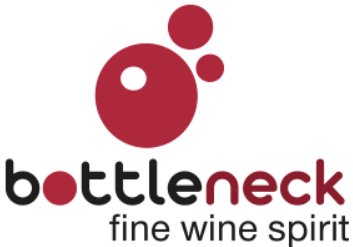

# OBJECTIF DE CE NOTEBOOK

Optimisez la gestion des données de la boutique à l'aide de Python.

Phase 1 : Agréger les différents fichiers afin de pouvoir exploiter les données.

    rapprocher l’extraction de la BDD avec la base de données ERP via la table de liaison ;
    identifier les erreurs dans les données (je pense que tu peux en trouver au moins 8 : erreurs de saisie, de type, de calcul, de jointure, etc.) ;
    proposer des solutions pour améliorer les données dans nos systèmes.

Phase 2 : Analyser les données pour le CODIR.

    Calculer le chiffre d’affaires :
        par produit ;
        le total général.
    Travailler sur les tops références, le 20/80, etc.
    Vérifier les erreurs de saisie en détectant des potentielles valeurs aberrantes (tu peux utiliser un Z-Score ou l’écart interquartile).
    Extraire les valeurs aberrantes dans les prix (tu peux utiliser un boxplot pour la représentation) puis conclure si nous avons des erreurs de prix.
    Analyser l’état, les taux de marge, la rotation des stocks ou le nombre de mois de stock.
    Corrélation entre certaines données quantitatives (prix, prix d’achat, stock, ventes, prix HT et taux de marge, etc.).


#**Sommaire**


#Phase 1 - Nettoyage et agrégation des données


*   Étape 1 - Importation des librairies et chargement des fichiers
*   Étape 2 - Analyse exploratoire des fichiers
*   Étape 3 - Jonction des fichiers


#Phase 2 - Analyse des données


*   Étape 4 - Analyse de la variable product_type
*   Étape 5 - Analyse de la variable price
*   Étape 6 - Analyses du CA, des quantités vendues, des stocks et de la marge
*   Étape 7 - Analyse des correlations
*   Étape 8 - Mise à disposition de la nouvelle table en Excel






#**Phase 1** - Nettoyage et agrégation des données

##**Etape 1** - Importation des librairies et chargement des fichiers

###**1.1** - Importation des librairies

In [ ]:
# Importation des librairies
import pandas as pd
import numpy as np
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

In [ ]:
# Instruction permettant d'afficher toutes les colonnes d'un dataframe

pd.set_option('display.max_columns', None)

###**1.2** - Chargements des fichiers

Utilisation de Google Drive pour stocker les fichiers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importation du fichier web.xlsx
df_web = pd.read_excel("/content/drive/MyDrive/OpenClassrooms/Projet 6/web.xlsx")
# Importation du fichier erp.xlsx
df_erp = pd.read_excel("/content/drive/MyDrive/OpenClassrooms/Projet 6/erp.xlsx")
# Importation du fichier liaison.xlsx
df_liaison = pd.read_excel("/content/drive/MyDrive/OpenClassrooms/Projet 6/liaison.xlsx")

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


##**Etape 2** - Analyse exploratoire des fichiers

###**2.1** - Analyse exploratoire du fichier erp.xlsx

In [ ]:
# Fonction permettant d'afficher les dimensions d'un dataframe, cette requête étant demandé pour chaque fichier tout au long de ce notebook.

def dimensions(df):
    print("Le tableau comporte {} observation(s) ou article(s)".format(df.shape[0]))
    print("Le tableau comporte {} colonne(s)".format(df.shape[1]))

In [ ]:
dimensions(df_erp)

Le tableau comporte 825 observation(s) ou article(s)
Le tableau comporte 6 colonne(s)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
 5   purchase_price  825 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 38.8+ KB


<Axes: >

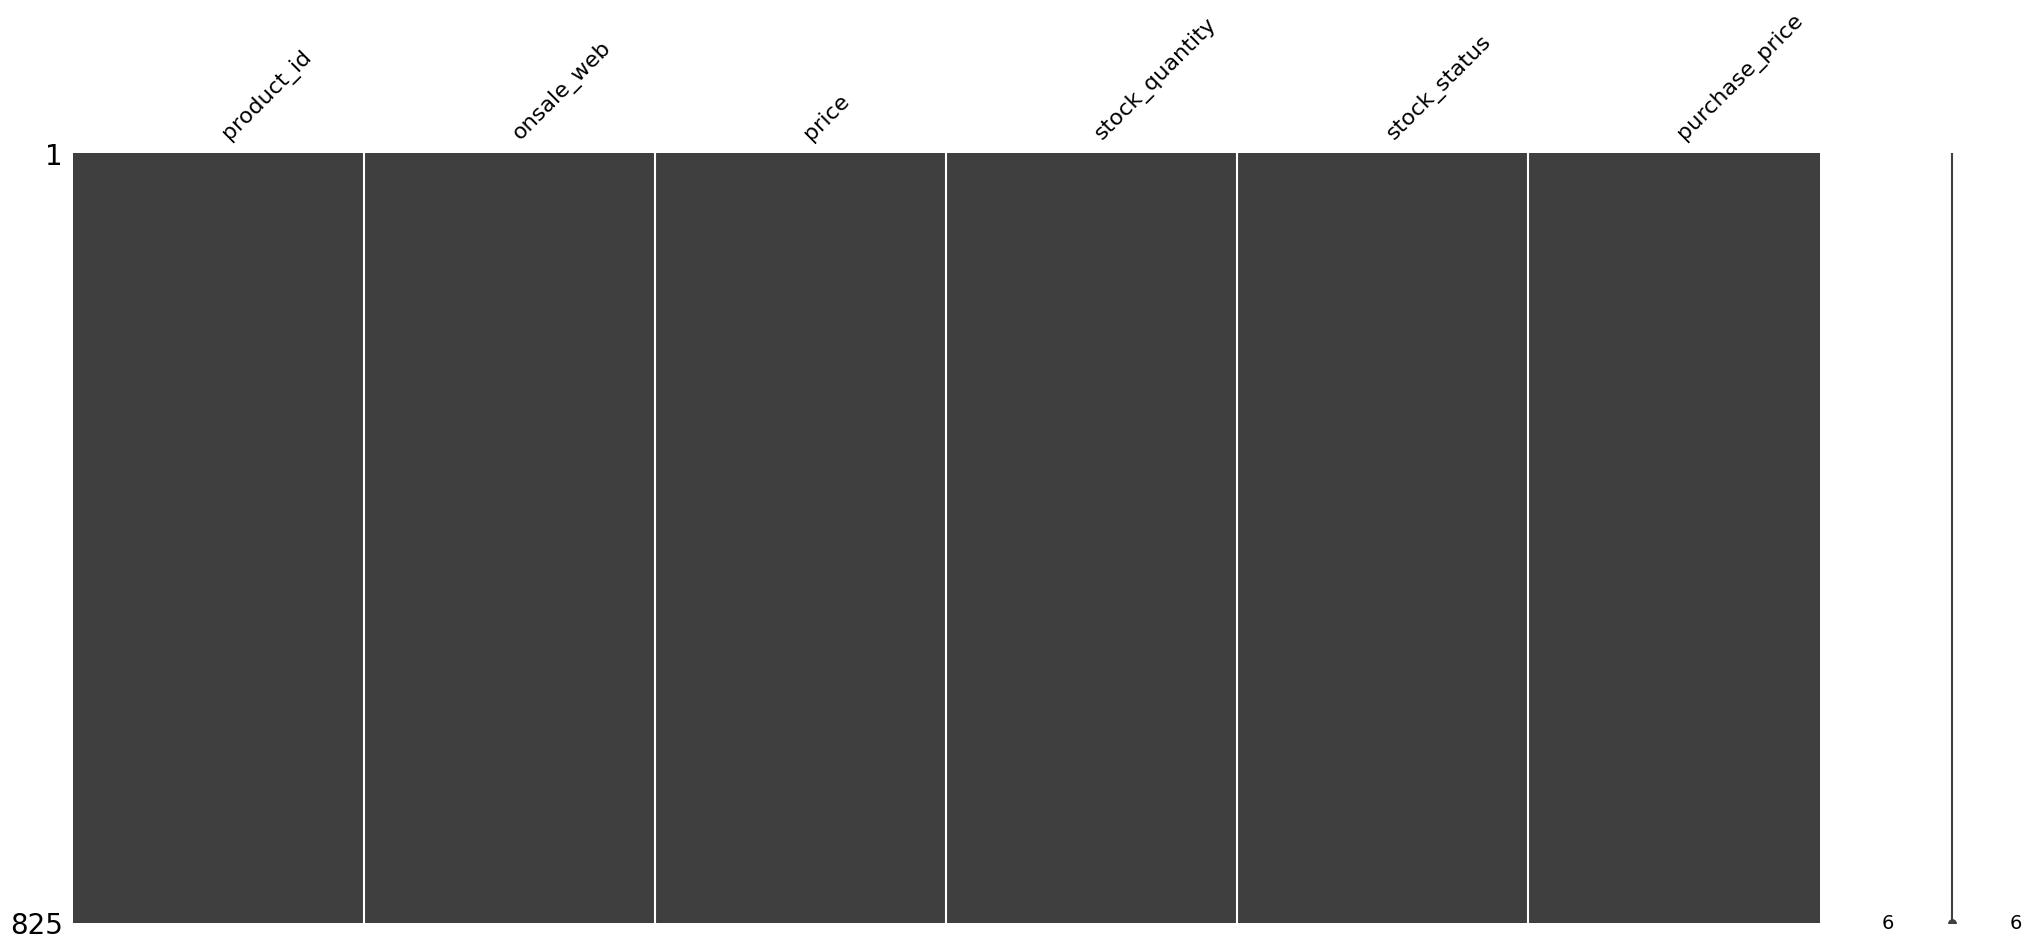

In [ ]:
# Consulatation de la nature des données et du nombre de valeurs présentes dans chacune des colonnes.
df_erp.info()
msno.matrix(df_erp)

Il ne semble pas y avoir de colonne avec des valeurs manquantes.

In [ ]:
# Affichage des 5 premières lignes de la table
df_erp.head()

,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price
0,3847,1,24.2,16,instock,12.88
1,3849,1,34.3,10,instock,17.54
2,3850,1,20.8,0,outofstock,10.64
3,4032,1,14.1,26,instock,6.92
4,4039,1,46.0,3,outofstock,23.77


Les données de l'ERP contiennent des informations sur le code produit, la vente en ligne ou non, le prix d'achat et le prix de vente, la quantité en stock ainsi que le statut de ce stock.

Nous allons à présent nous attarder sur chacune des variables(colonnes) de ce dataset.

####**2.1.1** - Analyse exploratoire de chaque variable du fichier erp.xlsx

#####**2.1.1.1** - Analyse de la variable product_id

In [ ]:
# Vérification des doublons dans la colonne
df_erp.loc[df_erp['product_id'].duplicated(keep=False),:]

,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price


Pas de doublons présent dans la colonne product_id, chaque référence produit est donc unique.

#####**2.1.1.2** - Analyse de la variable onsale_web

In [ ]:
# Vérification de la colonne onsale_web et des valeurs qu'elle contient.
df_erp['onsale_web'].value_counts()

,count
onsale_web,
1,716
0,109


Il y a 716 références vendues en ligne tandis que 109 ne sont vendues qu'en magasin.

Il y a un lien à faire entre les références marqués "1" et les références du fichier web.

#####**2.1.1.3** - Analyse de la variable price

In [ ]:
# Vérification des valeurs de la colonne.
print(df_erp['price'].describe())

count    825.000000
mean      32.187697
std       26.712077
min      -20.000000
25%       14.500000
50%       24.300000
75%       42.000000
max      225.000000
Name: price, dtype: float64


Il semble y avoir une erreur dans les prix, il y a un minimum à "-20".

In [ ]:
# Affichage du ou des prix inférieurs à 0.
df_erp.query("price <0")

,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price
151,4233,0,-20.0,0,outofstock,10.33
469,5017,0,-8.0,0,outofstock,4.34
739,6594,0,-9.1,19,instock,4.61


Il doit s'agir d'une erreur de frappe, en comparant avec la colonne "purchase_price" le prix de vente semble être plus ou moins le double du prix d'achat.

En accord avec l'expert métier je retire le négatif de la valeur.


In [ ]:
df_erp['price'] = df_erp['price'].abs()

Vérifions maintenant si nous avons des prix de vente inférieures au prix d'achat.

In [ ]:
df_incorrect_prix = df_erp[df_erp['price'] < df_erp['purchase_price']]
display(df_incorrect_prix)

,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price
210,4355,1,12.65,97,instock,77.48
391,4864,0,8.30,0,outofstock,9.99
724,6324,0,92.00,18,instock,99.00
817,7196,0,31.00,55,instock,31.20


Il y a sans doute une erreur de prix dans l'une des deux colonnes, ne sachant pas corrigé cette erreur et en accord avec l'expert métier je supprime ces lignes du dataframe.

In [ ]:
df_erp = df_erp.drop(df_incorrect_prix.index)
df_erp = df_erp.reset_index(drop=True)

#####**2.1.1.4** - Analyse de la variable stock_quantity

In [ ]:
# Vérification des valeurs de la colonne.
print(df_erp['stock_quantity'].describe())

count    821.000000
mean      21.487211
std       21.784116
min      -10.000000
25%        7.000000
50%       18.000000
75%       30.000000
max      145.000000
Name: stock_quantity, dtype: float64


On retrouve ici aussi une erreur avec un minimum à "-10".

In [ ]:
# Affichage du ou des stocks inférieurs à 0.
df_erp.query("stock_quantity <0")

,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price
447,4973,0,10.0,-10,outofstock,4.96
571,5700,1,44.5,-1,outofstock,22.30


In [ ]:
# Remplacement des quantités négatives par 0.
df_erp['stock_quantity'] = df_erp['stock_quantity'].replace([-10, -1], 0)

#####**2.1.1.5** - Analyse de la variable stock_status

In [ ]:
# Affichage des valeurs distinctes de la colonne stock_status.
df_erp["stock_status"].unique()

array(['instock', 'outofstock'], dtype=object)

Cette colonne est liée à stock_quantity, vérifions s'il y a des incohérences entre les valeurs de stock_quantity et stock_status.

In [ ]:
# Création d'une colonne "stock_status_2
# La valeur de cette deuxième colonne sera en fonction de la valeur dans la colonne "stock_quantity"
# Si la valeur de la colonne "stock_quantity" est nulle renseigner "outofstock" sinon mettre "instock"
df_erp['stock_status_2'] = df_erp['stock_quantity'].apply(lambda x: 'outofstock' if x <= 0 else 'instock')

In [ ]:
# Vérifions que les 2 colonnes sont identiques:
# Nous devrions obtenir la somme de 821 qui correspond au nombre de lignes dans ce dataset
comparaison = df_erp["stock_status"] == df_erp["stock_status_2"]
true_count = comparaison.sum()
false_count = len(comparaison) - true_count

print(f"Nombre de valeurs identiques (True): {true_count}")
print(f"Nombre de valeurs différentes (False): {false_count}")

Nombre de valeurs identiques (True): 819
Nombre de valeurs différentes (False): 2


2 valeurs de "stock_status" sont incohérentes par rapport à "stock_quantity".

In [ ]:
# Trouvons les lignes différentes
comparaison.loc[comparaison == False]

,0
4,False
396,False


In [ ]:
df_erp.iloc[[4, 396],:]

,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price,stock_status_2
4,4039,1,46.0,3,outofstock,23.77,instock
396,4885,1,18.7,0,instock,9.66,outofstock


In [ ]:
# Correction des données incohérentes
df_erp.iloc[[4, 396], df_erp.columns.get_loc('stock_status')] = df_erp.iloc[[4, 396], df_erp.columns.get_loc('stock_status_2')]

# Verification en utilisant le même code que plus haut pour afficher les problemes
comparaison = df_erp["stock_status"] == df_erp["stock_status_2"]
true_count = comparaison.sum()
false_count = len(comparaison) - true_count

print(f"Nombre de valeurs identiques (True): {true_count}")
print(f"Nombre de valeurs différentes (False): {false_count}")

Nombre de valeurs identiques (True): 821
Nombre de valeurs différentes (False): 0


Tout est rentré dans l'ordre, il n'y a plus d'incohérence.

#####**2.1.1.6** - Analyse de la variable purchase_price

In [ ]:
# Vérification des valeurs de la colonne.
print(df_erp['purchase_price'].describe())

count    821.000000
mean      16.757990
std       14.144252
min        2.740000
25%        7.560000
50%       12.690000
75%       22.010000
max      137.810000
Name: purchase_price, dtype: float64


Cette dernière variable paraît conforme, pas d'erreur dans les prix avec un minimum à 2.74.

En accord avec l'expert métier je supprime les colonnes inutiles pour la suite, "stock_status" et "stock_status_2" celles-ci sont redondantes avec "stock_quantity".

In [ ]:
df_erp.drop(['stock_status', 'stock_status_2'], axis=1, inplace=True)

Avant de passer au fichier suivant je converti certaines colonnes afin de respecter une logique.

In [ ]:
df_erp = df_erp.astype({'product_id': str, 'onsale_web': bool})
df_erp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      821 non-null    object 
 1   onsale_web      821 non-null    bool   
 2   price           821 non-null    float64
 3   stock_quantity  821 non-null    int64  
 4   purchase_price  821 non-null    float64
dtypes: bool(1), float64(2), int64(1), object(1)
memory usage: 26.6+ KB


###**2.2** - Analyse exploratoire du fichier web.xlsx


In [ ]:
dimensions(df_web)

Le tableau comporte 1513 observation(s) ou article(s)
Le tableau comporte 29 colonne(s)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    1428 non-null   object        
 1   virtual                1513 non-null   int64         
 2   downloadable           1513 non-null   int64         
 3   rating_count           1513 non-null   int64         
 4   average_rating         1430 non-null   float64       
 5   total_sales            1430 non-null   float64       
 6   tax_status             716 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1430 non-null   float64       
 9   post_date              1430 non-null   datetime64[ns]
 10  post_date_gmt          1430 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  product_type           1429 non-null   object        
 13  pos

<Axes: >

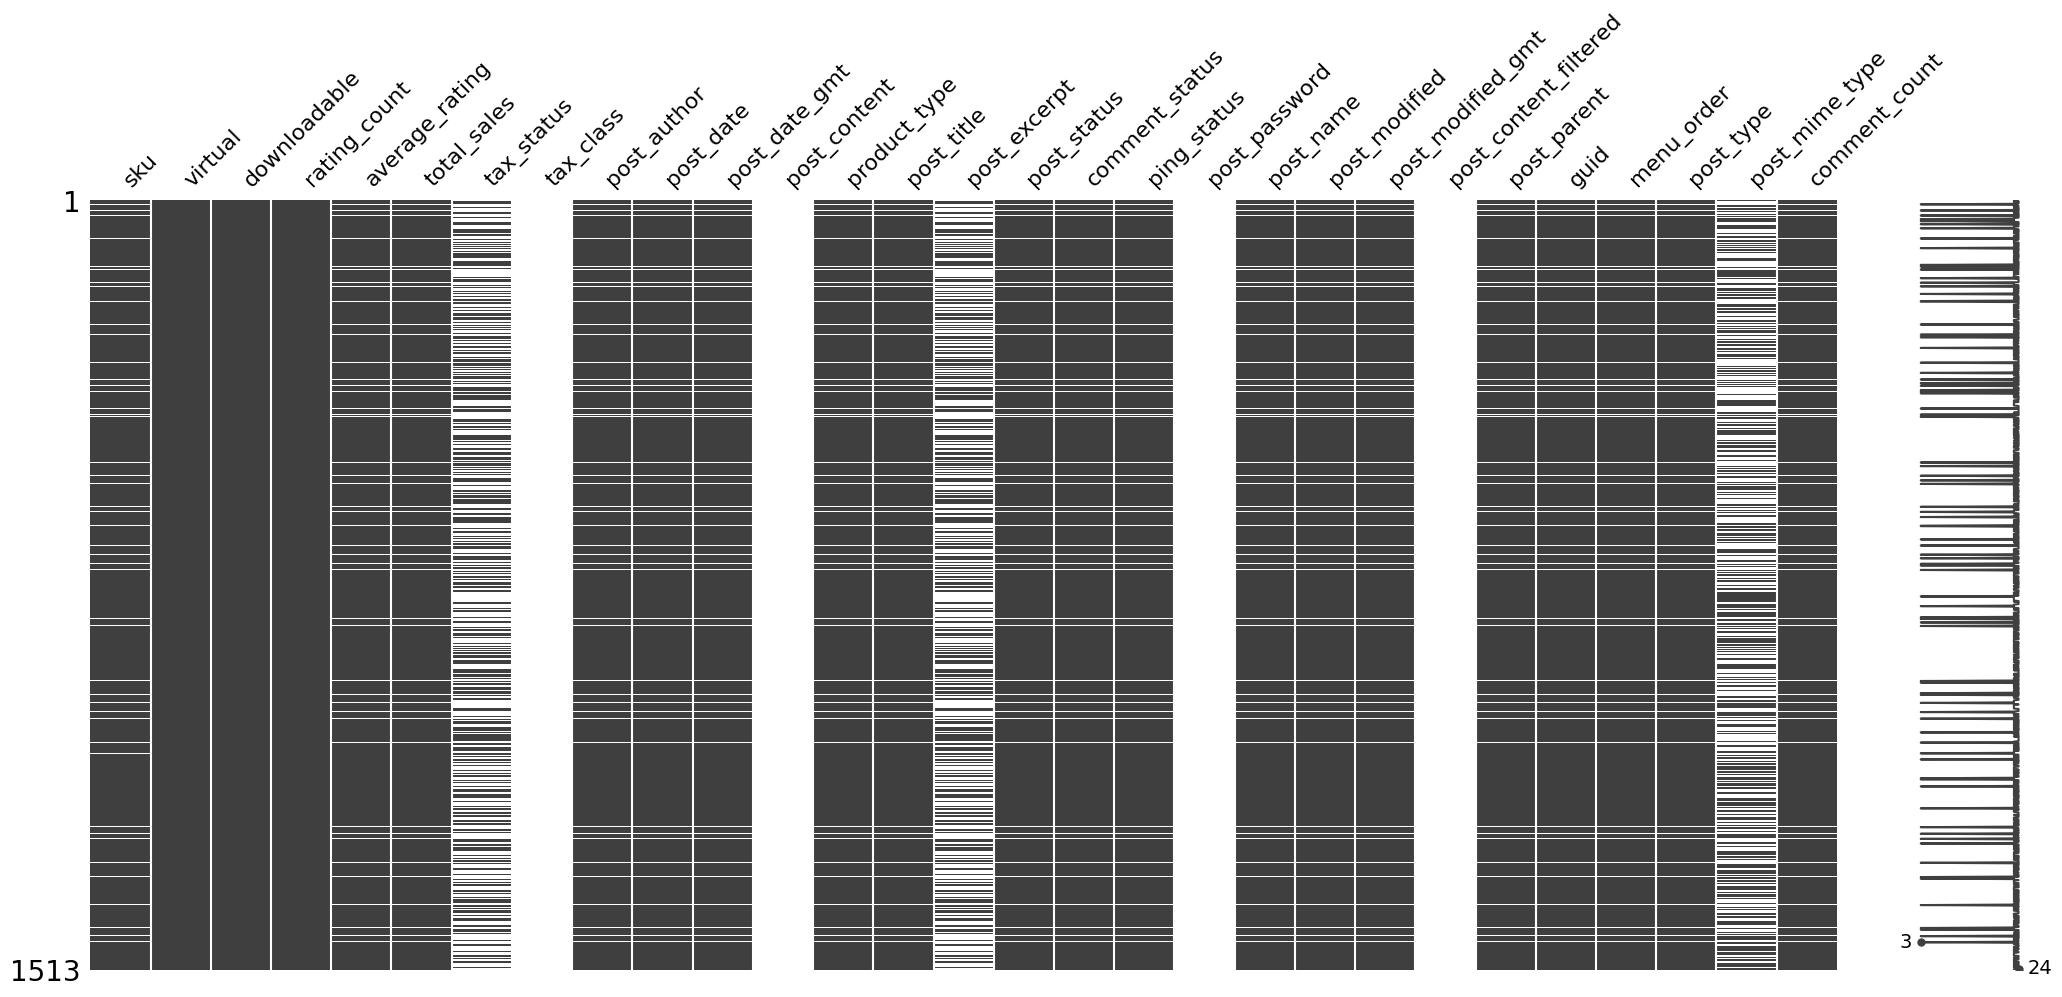

In [ ]:
df_web.info()
msno.matrix(df_web)

Les données web nous donnent énormément d'informations réparties sur 29 colonnes, on constate des valeurs nulles dans certaines colonnes et des colonnes complètement vides. avant d'aller plus loin je vais déjà décider des colonnes à supprimer pour alléger le fichier et faciliter l'analyse.

In [ ]:
df_web.head(3)

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,product_type,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,11862,0,0,0,0.0,3.0,NaN,NaN,2.0,2018-02-12 13:46:23,2018-02-12 12:46:23,NaN,Vin,Gilles Robin Hermitage Rouge 2012,NaN,publish,closed,closed,NaN,gilles-robin-hermitage-2012,2019-01-31 12:12:56,2019-01-31 11:12:56,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1,16057,0,0,0,0.0,5.0,NaN,NaN,2.0,2018-04-17 15:29:17,2018-04-17 13:29:17,NaN,Vin,Domaine Pellé Sancerre Rouge La Croix Au Garde...,NaN,publish,closed,closed,NaN,pelle-sancerre-rouge-la-croix-au-garde-2017,2020-07-07 10:05:02,2020-07-07 08:05:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
2,14692,0,0,0,0.0,5.0,taxable,NaN,2.0,2019-03-19 10:06:47,2019-03-19 09:06:47,NaN,Vin,Château Fonréaud Bordeaux Blanc Le Cygne 2016,<div>Grâce à la complémentarité des 3 cépages ...,publish,closed,closed,NaN,fonreaud-bordeaux-blanc-le-cygne-2016,2020-04-25 21:40:31,2020-04-25 19:40:31,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [ ]:
# Suppression des lignes inutiles pour l'analyse.
col_to_delete = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28]
df_web.drop(df_web.columns[col_to_delete], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sku           1428 non-null   object 
 1   total_sales   1430 non-null   float64
 2   product_type  1429 non-null   object 
 3   post_title    1430 non-null   object 
 4   post_type     1430 non-null   object 
dtypes: float64(1), object(4)
memory usage: 59.2+ KB


<Axes: >

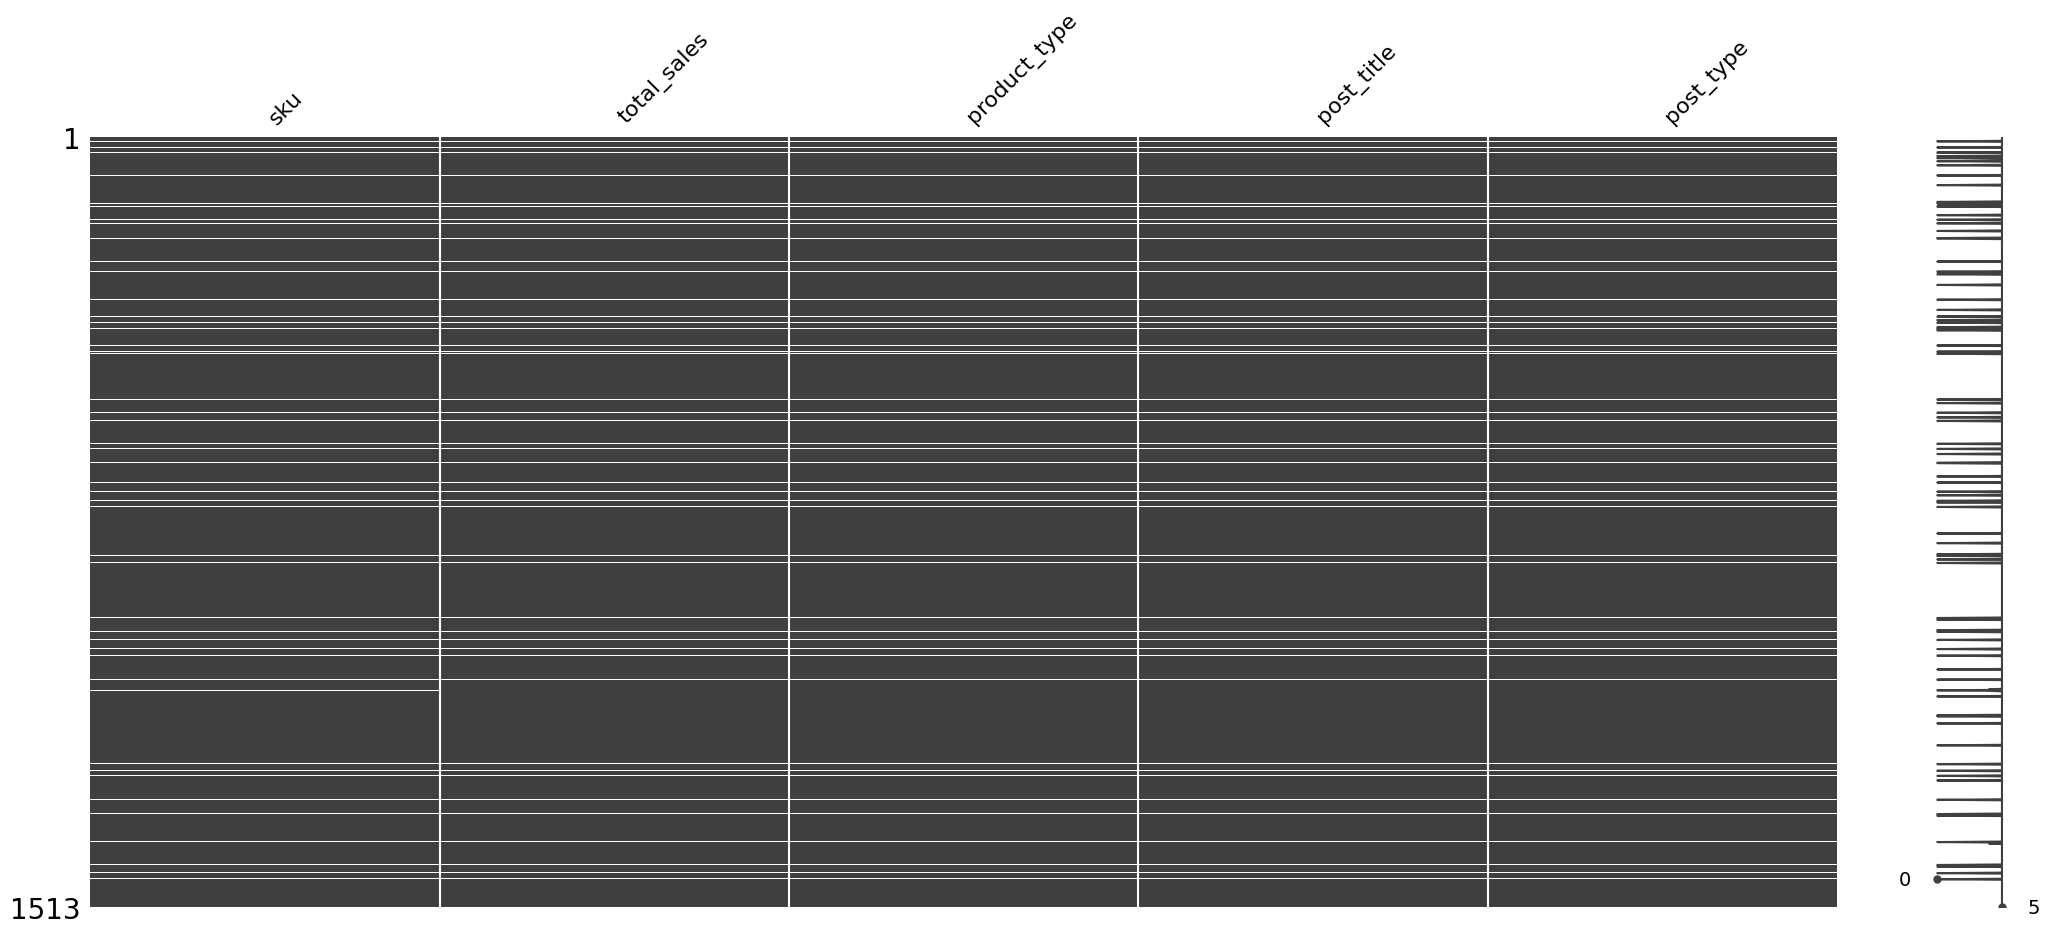

In [ ]:
df_web.info()
msno.matrix(df_web)

Il y a des lignes ou toutes les colonnes sont vides, nous allons les supprimer.

In [ ]:
df_web = df_web.dropna(how='all')

<Axes: >

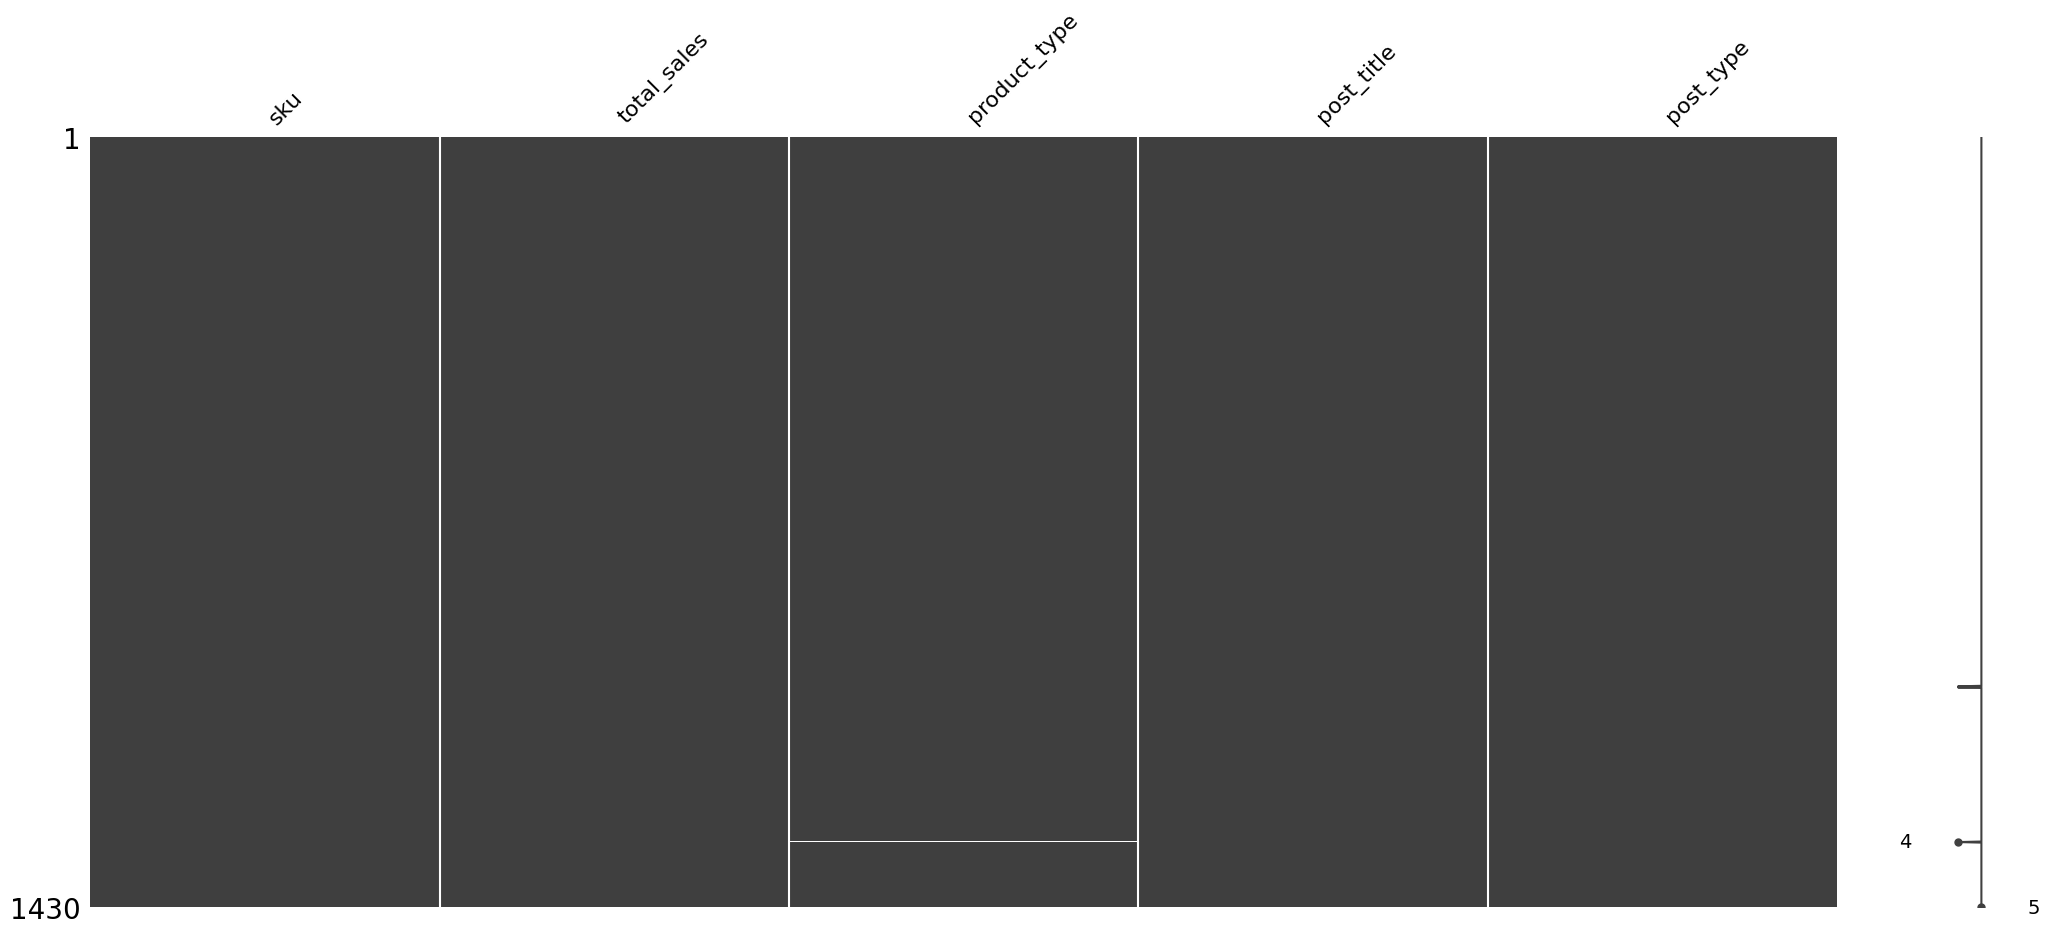

In [ ]:
msno.matrix(df_web)

Il reste une ligne ou "product_type" est nulle, nous allons vérifier celle-ci.

In [ ]:
df_web.query('product_type.isna()')

,sku,total_sales,product_type,post_title,post_type
1387,bon-cadeau-25-euros,7.0,NaN,Bon cadeau de 25€,product


Je n'y touche pas pour le moment, le sku(code produit) est différent de ce que j'ai pu voir précédement, nous y reviendrons plus tard.

####**2.2.1** - Analyse exploratoire de chaque variable du fichier web.xlsx

#####**2.2.1.1** - Analyse de la variable sku

In [ ]:
df_web['sku'].unique()

array([11862, 16057, 14692, 16295, 15328, 15471, 16515, 16246, 13572,
       16513, 16585, 16269, 15526, 12869, 15575, 11586, 14338, 15425,
       16560, 15361, 13809, 11587, 15022, 14323, 16342, 16029, 15475,
       13754, 14680, 15875, 9636, 13849, 13662, 16564, 13557, 15429,
       14712, 15032, 15481, 15448, 16580, 15441, 804, 15300, 13958, 16071,
       15678, 13895, 15711, 12882, 16053, 13766, 16247, 12640, 15292,
       15476, 15670, 16189, 16038, 14864, 16044, 15324, 15531, 15953,
       15413, 15733, 14366, 15895, 15892, 16472, 15185, 16010, 15793,
       15849, 12315, 15741, 15934, 15148, 15781, 15659, 15106, 15490,
       14507, 14149, 16307, 13736, 14090, 16037, 15758, 14661, 12587,
       15337, 15489, 15201, 16305, 16131, 13435, 15747, 12203, 14509,
       14768, 16262, 14561, 16505, 15717, 16129, 13460, 15871, 15940,
       11602, 13127, 13520, 15480, 13032, 15436, 15269, 15910, 19821,
       16263, 15138, 15146, 15126, 15482, 16186, 13905, 16540, 15856,
       15677, 14

Les sku sont cohérents hormis 'bon_cadeau-25-euros', '13127-1' et 'nan', vérifions maintenant qu'il n'y a pas de doublons.

In [ ]:
df_web.loc[df_web['sku'].duplicated(keep=False)]

,sku,total_sales,product_type,post_title,post_type
0,11862,3.0,Vin,Gilles Robin Hermitage Rouge 2012,attachment
1,16057,5.0,Vin,Domaine Pellé Sancerre Rouge La Croix Au Garde...,attachment
2,14692,5.0,Vin,Château Fonréaud Bordeaux Blanc Le Cygne 2016,product
3,16295,14.0,Vin,Moulin de Gassac IGP Pays d'Hérault Guilhem Ro...,attachment
4,15328,2.0,Vin,Agnès Levet Côte Rôtie Maestria 2017,product
...,...,...,...,...,...
1508,16326,5.0,Vin,Camin Larredya Jurançon Moelleux Au Capcéu 2018,product
1509,15662,15.0,Vin,Chermette Domaine du Vissoux Beaujolais Griott...,product
1510,15329,3.0,Vin,Agnès Levet Côte Rôtie Péroline 2017,attachment
1511,14827,7.0,Vin,Marc Colin Et Fils Chassagne-Montrachet Blanc ...,attachment


Il semblerait que tous les sku soient en doublons (1430 lignes), nous allons vérifier si ces doublons s'applique au reste des colonnes.

In [ ]:
# Conversion de "sku" en string pour trier
df_web['sku'] = df_web['sku'].astype(str)

df_web_sorted = df_web.sort_values(by='sku')
df_web_doublons_sku = df_web_sorted.groupby('sku')

In [ ]:
df_web_doublons_sku.head()

,sku,total_sales,product_type,post_title,post_type
668,10014,10.0,Gin,Darnley's London Dry Gin Original,product
1030,10014,10.0,Gin,Darnley's London Dry Gin Original,attachment
887,10459,4.0,Vin,Alphonse Mellot Sancerre Rouge Génération XIX ...,attachment
748,10459,4.0,Vin,Alphonse Mellot Sancerre Rouge Génération XIX ...,product
1317,10775,6.0,Vin,Albert Mann Pinot Gris Vendanges Tardives Alte...,attachment
...,...,...,...,...,...
167,9937,2.0,Vin,Marcel Richaud Cairanne Rouge Les Estrambords ...,product
1387,bon-cadeau-25-euros,7.0,NaN,Bon cadeau de 25€,product
842,bon-cadeau-25-euros,7.0,Autre,Bon cadeau de 25€,attachment
1084,nan,-56.0,Vin,Pierre Jean Villa Condrieu Jardin Suspendu 2018,product


Les lignes ont l'air d'être identiques sur toutes les colonnes hormis 'post_type', on comprend qu'il doit s'agir du même produit mais 'product' correpond au produit en lui-même et 'attachment' à la pièce-jointe(photo) du produit.

Je vais revenir sur ma ligne NaN en "product_type" pour la corriger.

In [ ]:
# Recherche du doublons sur "post"title".
df_web.query("post_title == 'Bon cadeau de 25€'")

,sku,total_sales,product_type,post_title,post_type
842,bon-cadeau-25-euros,7.0,Autre,Bon cadeau de 25€,attachment
1387,bon-cadeau-25-euros,7.0,NaN,Bon cadeau de 25€,product


In [ ]:
# Remplacement de NaN par 'Autre' uniquement pour les lignes où 'sku' est 'bon-cadeau-25-euros'
df_web.loc[(df_web['sku'] == 'bon-cadeau-25-euros') & (df_web['product_type'].isna()), 'product_type'] = 'Autre'

df_web.query("post_title == 'Bon cadeau de 25€'")

,sku,total_sales,product_type,post_title,post_type
842,bon-cadeau-25-euros,7.0,Autre,Bon cadeau de 25€,attachment
1387,bon-cadeau-25-euros,7.0,Autre,Bon cadeau de 25€,product


Regardons la référence '13127-1'

In [ ]:
df_web.query("sku == '13127-1'")

,sku,total_sales,product_type,post_title,post_type
272,13127-1,4.0,Vin,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,product
1117,13127-1,4.0,Vin,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,attachment


Mise à part une erreur de formatage sur la référence le reste est correct, je décide de ne rien supprimer en attendant la fusion des fichiers.

Attardons nous maintenant sur les lignes nan en sku.

In [ ]:
df_web.query("sku == 'nan'")

,sku,total_sales,product_type,post_title,post_type
1084,nan,-56.0,Vin,Pierre Jean Villa Condrieu Jardin Suspendu 2018,product
1087,nan,-17.0,Vin,Pierre Jean Villa Côte Rôtie Fongeant 2017,product


In [ ]:
df_web.query("post_title == 'Pierre Jean Villa Condrieu Jardin Suspendu 2018' or post_title == 'Pierre Jean Villa Côte Rôtie Fongeant 2017'")

,sku,total_sales,product_type,post_title,post_type
1084,nan,-56.0,Vin,Pierre Jean Villa Condrieu Jardin Suspendu 2018,product
1087,nan,-17.0,Vin,Pierre Jean Villa Côte Rôtie Fongeant 2017,product


Ces lignes n'ont pas de doublons en 'attachment' donc pas de possiblité de récupérer un sku, de plus le "total_sales" est négatif.

En accord avec l'expert métier je supprime ces 2 lignes du dataframe.

In [ ]:
df_web = df_web[df_web['sku'] != 'nan']

#####**2.2.1.2** - Analyse de la variable total_sales

In [ ]:
df_web['total_sales'].describe()

,total_sales
count,1428.000000
mean,8.285714
std,6.473569
min,0.000000
25%,5.000000
50%,8.000000
75%,11.000000
max,122.000000


Il n'y pas plus de valeurs négatives dans la colonne total_sales.

In [ ]:
# Grouper par 'sku' et vérifier les valeurs uniques dans 'total_sales'
unique_sales = df_web.groupby('sku')['total_sales'].nunique()
sku_with_diff_sales = unique_sales[unique_sales > 1].index

# Filtrer les lignes où 'sku' est dans les 'sku' avec des valeurs différentes dans 'total_sales'
resultat_doublons_diff = df_web[df_web['sku'].isin(sku_with_diff_sales)].sort_values(by='sku')

print("Lignes avec des doublons de 'sku' et des valeurs différentes dans 'total_sales':")
display(resultat_doublons_diff)

Lignes avec des doublons de 'sku' et des valeurs différentes dans 'total_sales':


,sku,total_sales,product_type,post_title,post_type
523,1366,116.0,Champagne,Champagne Mailly Grand Cru Intemporelle 2010,attachment
548,1366,6.0,Champagne,Champagne Mailly Grand Cru Intemporelle 2010,product
114,14561,111.0,Vin,Argentine Mendoza Alamos Torrontes 2017,attachment
1052,14561,11.0,Vin,Argentine Mendoza Alamos Torrontes 2017,product
452,14950,122.0,Vin,François Baur Pinot Noir Schlittweg 2017,attachment
999,14950,22.0,Vin,François Baur Pinot Noir Schlittweg 2017,product
219,15346,22.0,Vin,Albert Mann Pinot Noir Grand H 2017,attachment
843,15346,2.0,Vin,Albert Mann Pinot Noir Grand H 2017,product


On constate 4 références de produits avec un nombre de ventes différent entre 'product' et 'attachment'. En accord avec l'expert métier je vais imputer les valeurs en prenant la moyenne d'un même groupe.

In [ ]:
# Calcul de la moyenne de 'total_sales' pour chaque groupe de 'sku'
df_web['total_sales'] = df_web.groupby('sku')['total_sales'].transform('mean')

df_web.query("sku == '1366' or sku == '14561' or sku == '14950' or sku == '15346'").sort_values(by='sku')

,sku,total_sales,product_type,post_title,post_type
523,1366,61.0,Champagne,Champagne Mailly Grand Cru Intemporelle 2010,attachment
548,1366,61.0,Champagne,Champagne Mailly Grand Cru Intemporelle 2010,product
114,14561,61.0,Vin,Argentine Mendoza Alamos Torrontes 2017,attachment
1052,14561,61.0,Vin,Argentine Mendoza Alamos Torrontes 2017,product
452,14950,72.0,Vin,François Baur Pinot Noir Schlittweg 2017,attachment
999,14950,72.0,Vin,François Baur Pinot Noir Schlittweg 2017,product
219,15346,12.0,Vin,Albert Mann Pinot Noir Grand H 2017,attachment
843,15346,12.0,Vin,Albert Mann Pinot Noir Grand H 2017,product


#####**2.2.1.3** - Analyse de la variable product_type

In [ ]:
df_web['product_type'].value_counts()

,count
product_type,
Vin,1316
Champagne,56
Whisky,28
Cognac,16
Huile d'olive,6
Gin,4
Autre,2


Le vin est prédominant avec 20 fois de plus référence que le champagne suivi du whisky qui à 2 fois de référence que celui-ci. Quelques références de cognac puis nous retrouvons très peu de référence dans l'huile d'olive et le gin. 2 références dans 'Autre' qui correspond au bon d'achat de 25€.

In [ ]:
# Grouper par 'sku' et vérifier les valeurs uniques dans 'product_type'
unique_type = df_web.groupby('sku')['product_type'].nunique()
sku_with_diff_type = unique_type[unique_type > 1].index

# Filtrer les lignes où 'sku' est dans les 'sku' avec des valeurs différentes dans 'product_type'
resultat_doublons_diff_2 = df_web[df_web['sku'].isin(sku_with_diff_type)].sort_values(by='sku')

print("Lignes avec des doublons de 'sku' et des valeurs différentes dans 'product_type':")
display(resultat_doublons_diff_2)

Lignes avec des doublons de 'sku' et des valeurs différentes dans 'product_type':


,sku,total_sales,product_type,post_title,post_type


Il n'y a pas d'erreur de type de produit pour une même référence.

#####**2.2.1.4** - Analyse de la variable post_title

In [ ]:
# Grouper par 'sku' et vérifier les valeurs uniques dans 'post_title'
unique_title = df_web.groupby('sku')['post_title'].nunique()
sku_with_diff_title = unique_title[unique_title > 1].index

# Filtrer les lignes où 'sku' est dans les 'sku' avec des valeurs différentes dans 'product_type'
resultat_doublons_diff_3 = df_web[df_web['sku'].isin(sku_with_diff_title)].sort_values(by='sku')

print("Lignes avec des doublons de 'sku' et des valeurs différentes dans 'product_type':")
display(resultat_doublons_diff_3)

Lignes avec des doublons de 'sku' et des valeurs différentes dans 'product_type':


,sku,total_sales,product_type,post_title,post_type


Il n'y a pas d'erreur de titre de produit pour une même référence.

In [ ]:
df_web['post_title'].value_counts()

,count
post_title,
Clos du Mont-Olivet Châteauneuf-du-Pape 2007,4
Domaine Hauvette IGP Alpilles Jaspe 2017,4
Marc Colin Et Fils Chassagne-Montrachet Blanc Les Vide-Bourses 1er Cru 2016,4
Gilles Robin Hermitage Rouge 2012,2
Domaine de l'Hortus Pic Saint-Loup La Bergerie Rouge 2018,2
...,...
Emile Boeckel Riesling Brandluft 2018,2
Wemyss Malts Blended Malt Scotch Whisky The Hive Batch Strength,2
Albert Mann Pinot Gris Cuvée Albert 2017,2


On constate 3 produits qui reviennent 4 fois ce qui veut dire que ces 3 produits apparaissent chacun sur 2 références(sku) différentes.

In [ ]:
df_web.query("post_title == 'Clos du Mont-Olivet Châteauneuf-du-Pape 2007' or post_title == 'Domaine Hauvette IGP Alpilles Jaspe 2017' or post_title == 'Marc Colin Et Fils Chassagne-Montrachet Blanc Les Vide-Bourses 1er Cru 2016'").sort_values(by='post_title')

,sku,total_sales,product_type,post_title,post_type
272,13127-1,4.0,Vin,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,product
979,16034,8.0,Vin,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,product
1083,16034,8.0,Vin,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,attachment
1117,13127-1,4.0,Vin,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,attachment
62,15292,8.0,Vin,Domaine Hauvette IGP Alpilles Jaspe 2017,attachment
403,16068,5.0,Vin,Domaine Hauvette IGP Alpilles Jaspe 2017,attachment
680,15292,8.0,Vin,Domaine Hauvette IGP Alpilles Jaspe 2017,product
1056,16068,5.0,Vin,Domaine Hauvette IGP Alpilles Jaspe 2017,product
293,14828,0.0,Vin,Marc Colin Et Fils Chassagne-Montrachet Blanc ...,attachment
294,14000,4.0,Vin,Marc Colin Et Fils Chassagne-Montrachet Blanc ...,attachment


Etant donné qu'il y a une référence pour chacun attendons de voir après fusion des fichiers.

#####**2.2.1.5** - Analyse de la variable post_type

In [ ]:
df_web['post_type'].value_counts()

,count
post_type,
attachment,714
product,714


Rien à constater sur cette variable.

Avant de passer au fichier suivant et maintenant que toutes nos références sont identiques sur 'product' et 'attachment', il est inutile d'avoir des doublons.

En accord avec l'expert métier je filtre le dataframe pour ne garder que la catégorie 'product' puis supprime la colonne "product_type" car inutile pour la suite.

In [ ]:
df_web = df_web.query("post_type == 'product'")
df_web.drop(['post_type'], axis=1, inplace=True)

<ipython-input-55-cfb901bcd491>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_web.drop(['post_type'], axis=1, inplace=True)


Enfin, je converti les colonnes.

In [ ]:
df_web = df_web.astype({'sku': str, 'total_sales': int, 'product_type' : str, 'post_title' : str})
df_web.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 2 to 1509
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sku           714 non-null    object
 1   total_sales   714 non-null    int64 
 2   product_type  714 non-null    object
 3   post_title    714 non-null    object
dtypes: int64(1), object(3)
memory usage: 27.9+ KB


###**2.3** - Analyse exploratoire du fichier liaison.xlsx

In [ ]:
dimensions(df_liaison)

Le tableau comporte 825 observation(s) ou article(s)
Le tableau comporte 2 colonne(s)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_web      734 non-null    object
 1   product_id  825 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


<Axes: >

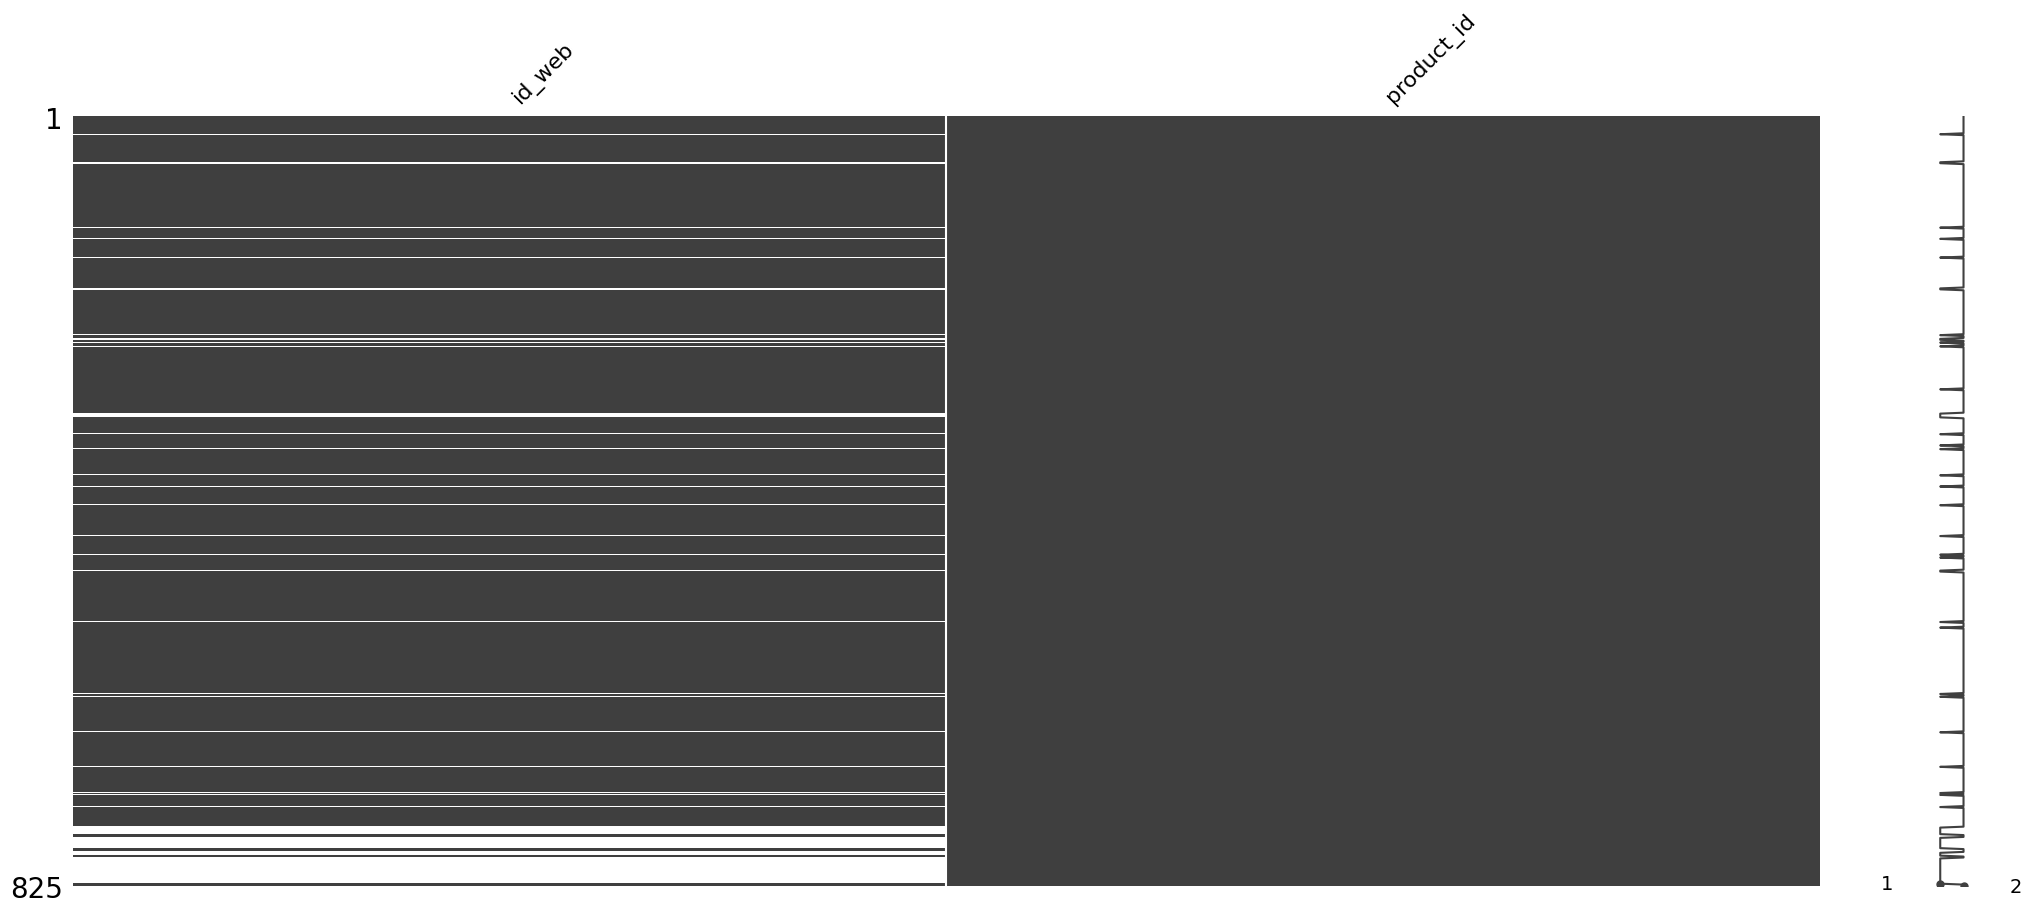

In [ ]:
df_liaison.info()
msno.matrix(df_liaison)

In [ ]:
# Vérification de l'unicité des données
display(df_liaison['product_id'].nunique())
display(df_liaison['id_web'].nunique())

825

734

Chaque valeur est unique mais il manque 91 références web en face des références erp dans ce fichier.

Je renomme la colonne "id_web"en "sku" pour plus de clarté et faciliter la liaison avec les autres fichiers.

In [ ]:
df_liaison.rename(columns={'id_web': 'sku'}, inplace=True)

Je converti les colonnes nécesssaires avant la fusion.

In [ ]:
df_liaison['product_id'] = df_liaison['product_id'].astype(str)

##**Etape 3** - Jonction des fichiers

###**3.1** - Jonction du fichier df_erp et df_liaison

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      821 non-null    object 
 1   onsale_web      821 non-null    bool   
 2   price           821 non-null    float64
 3   stock_quantity  821 non-null    int64  
 4   purchase_price  821 non-null    float64
 5   sku             732 non-null    object 
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 33.0+ KB


<Axes: >

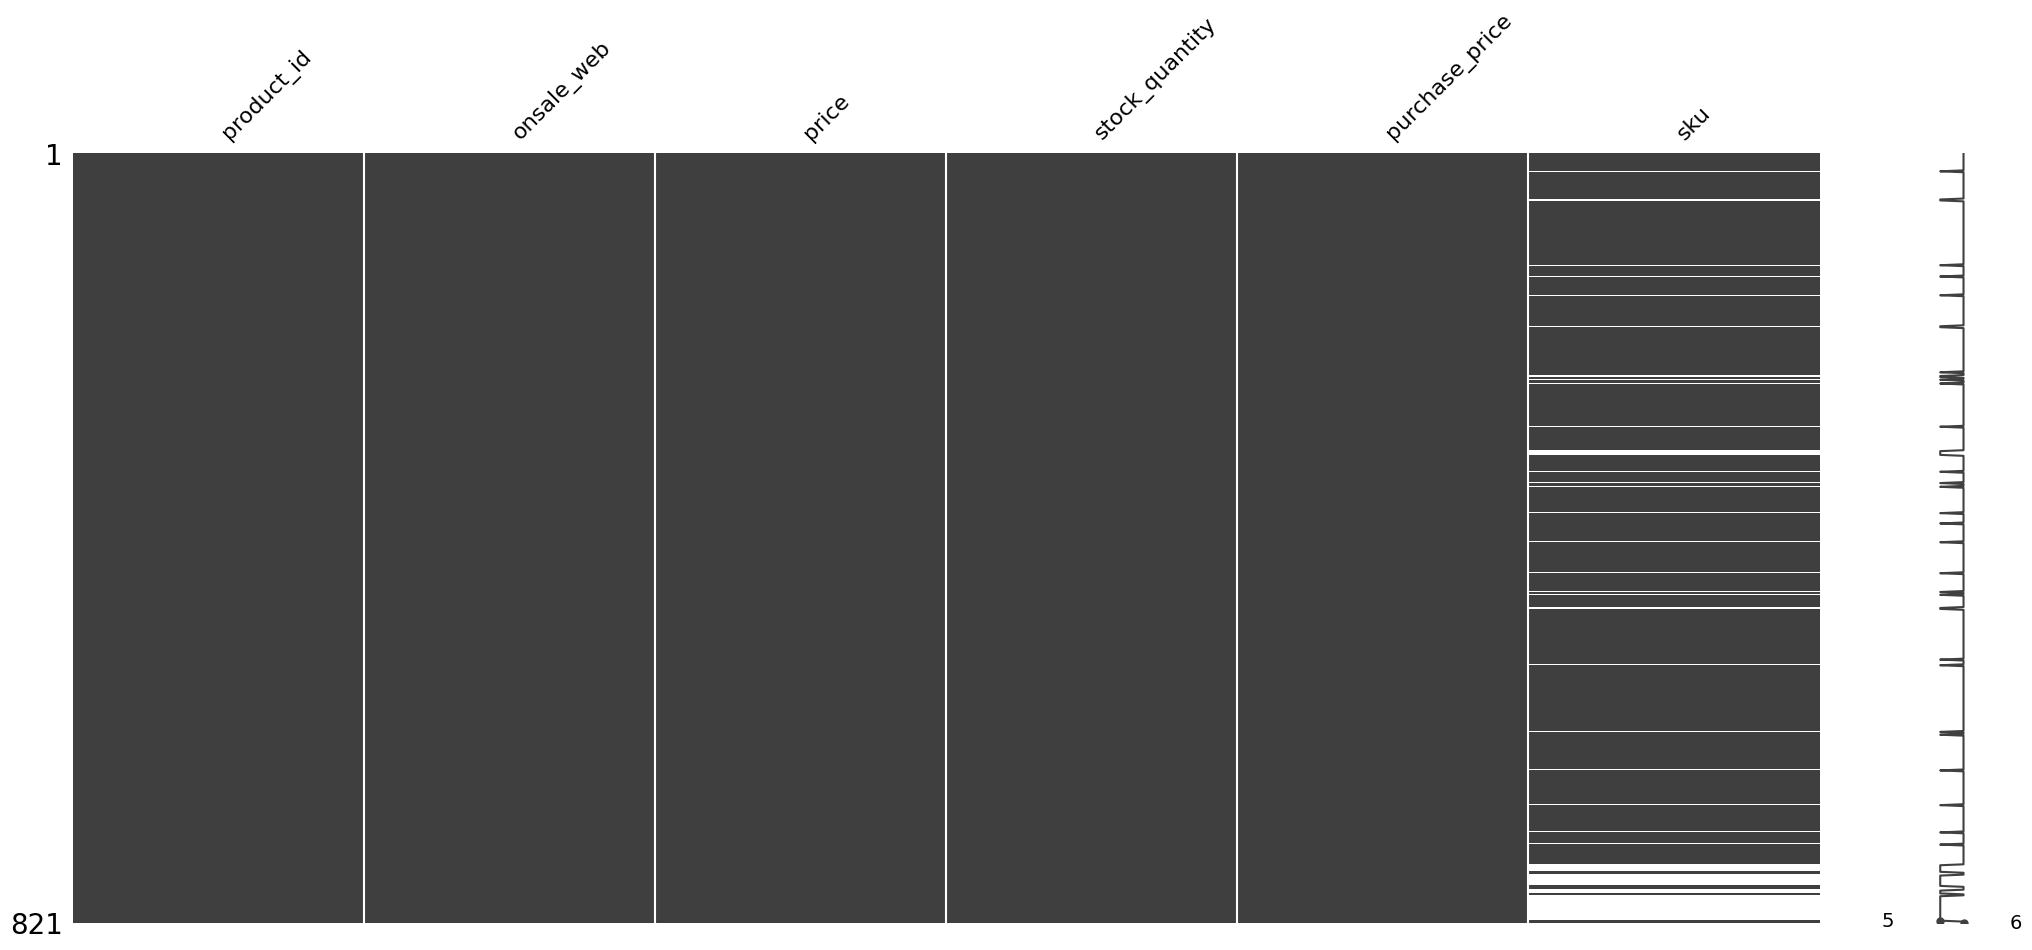

In [ ]:
df_merge = pd.merge(df_erp, df_liaison, on=['product_id'], how='left')
df_merge.info()
msno.matrix(df_merge)

Nous ne pourrons rien tirer comme analyse des références erp sans références web en face.

En accord avec l'expert métier je supprime toutes les lignes sans référence web(sku).

In [ ]:
df_merge = df_merge.query('sku == sku')
df_merge['sku'] = df_merge['sku'].astype(str)
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 0 to 820
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      732 non-null    object 
 1   onsale_web      732 non-null    bool   
 2   price           732 non-null    float64
 3   stock_quantity  732 non-null    int64  
 4   purchase_price  732 non-null    float64
 5   sku             732 non-null    object 
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 35.0+ KB


<ipython-input-63-130985350cd2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['sku'] = df_merge['sku'].astype(str)


###**3.2** - Jonction du fichier df_merge et df_web

In [ ]:
df_final = pd.merge(df_web, df_merge, on=['sku'], how='left')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sku             714 non-null    object 
 1   total_sales     714 non-null    int64  
 2   product_type    714 non-null    object 
 3   post_title      714 non-null    object 
 4   product_id      713 non-null    object 
 5   onsale_web      713 non-null    object 
 6   price           713 non-null    float64
 7   stock_quantity  713 non-null    float64
 8   purchase_price  713 non-null    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 50.3+ KB


Je réorganise l'ordre des colonnes pour plus de clarté.

In [ ]:
df_final = df_final[['product_id', 'sku', 'onsale_web', 'post_title', 'product_type', 'price', 'purchase_price', 'stock_quantity', 'total_sales']]
df_final.head()

,product_id,sku,onsale_web,post_title,product_type,price,purchase_price,stock_quantity,total_sales
0,5794,14692,True,Château Fonréaud Bordeaux Blanc Le Cygne 2016,Vin,21.70,10.65,15.0,5
1,5827,15328,True,Agnès Levet Côte Rôtie Maestria 2017,Vin,55.00,29.55,4.0,2
2,4964,16515,True,Château Turcaud Bordeaux Rouge Cuvée Majeure 2018,Vin,12.10,6.50,23.0,10
3,4223,16585,True,Xavier Frissant Touraine Sauvignon 2019,Vin,9.70,4.81,42.0,15
4,5900,12869,True,Stéphane Tissot Arbois D.D. 2016,Vin,18.25,8.96,21.0,7


In [ ]:
df_final.nunique()

,0
product_id,713
sku,714
onsale_web,2
post_title,711
product_type,7
price,361
purchase_price,589
stock_quantity,79
total_sales,26


Vérirication de la ligne comportant des NaN.

In [ ]:
df_final.query("product_id.isna()")

,product_id,sku,onsale_web,post_title,product_type,price,purchase_price,stock_quantity,total_sales
344,NaN,12589,NaN,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,Champagne,NaN,NaN,NaN,0


Il s'agit d'un article dont le prix de vente était inférieur au prix d'achat et que j'ai écarté directement dans le fichier erp. Je peux donc supprimer cette ligne.

In [ ]:
df_final = df_final.dropna(subset=['product_id'])
df_final = df_final.reset_index(drop=True)

Vérification de la variable "onsale_web" pour constater s'il y a une incohérence, je ne devrais pas retrouver de 'False' puisque j'ai une correspondance entre la référence web et erp.

In [ ]:
df_final.query("onsale_web == False")

,product_id,sku,onsale_web,post_title,product_type,price,purchase_price,stock_quantity,total_sales
523,4200,16295,False,Moulin de Gassac IGP Pays d'Hérault Guilhem Ro...,Vin,5.8,3.12,33.0,14


Il y a bien une erreur, plutôt que de la passer en 'True' je supprime cette colonne qui sera inutile car valeur unique.

In [ ]:
df_final.drop(columns=['onsale_web'], inplace=True)

Retournons sur nos références web ne respectant pas le format.

In [ ]:
df_final.query("sku == 'bon-cadeau-25-euros' or sku == '13127-1'")

,product_id,sku,post_title,product_type,price,purchase_price,stock_quantity,total_sales
126,7247,13127-1,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,Vin,54.8,27.18,6.0,4
654,4954,bon-cadeau-25-euros,Bon cadeau de 25€,Autre,25.0,13.30,23.0,7


Nous retrouvons bien une correspondance avec une référence de l'erp, malgré un format non conforme je garde ces valeurs car cela ne génera pas l'analyse.

In [ ]:
df_final['stock_quantity'] = df_final['stock_quantity'].astype(int)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      713 non-null    object 
 1   sku             713 non-null    object 
 2   post_title      713 non-null    object 
 3   product_type    713 non-null    object 
 4   price           713 non-null    float64
 5   purchase_price  713 non-null    float64
 6   stock_quantity  713 non-null    int64  
 7   total_sales     713 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 44.7+ KB


Le nettoyage des données est maintenant terminé, durant celui-ci j'ai constaté des erreurs que je vais lister par fichier.

erp.xlsx :
*   Erreur de type dans les colonnes 'product_id' et 'onsale_web'
*   Valeurs aberrantes dans les colonnes 'price' et 'stock_quantity' avec des
valeurs en négatif
*   Valeurs incohérentes dans la colonne 'stock_status' par rapport à la colonne 'stock_quantity' (ex: outofstock alors qu'il y a une valeur >0)
*   Erreur de contradiction dans la colonne 'onsale_web' une fois la fusion des fichiers effectuée
*   Valeurs incohérentes entre les colonnes 'price' et 'purchase_price', le prix de vente ne peut pas être inférieur au prix d'achat


---


web.xlsx :
*   Erreur de type dans les colonnes 'sku' et 'total_sales'
*   Lignes totalement vides dans toutes les colonnes
*   Erreur de formatage dans la colonne 'sku' avec des valeurs ne respectant pas le format
*   Erreur de contradiction dans la colonne 'total_sales', chaque référence produit est en doublons du fait des lignes 'product' et 'attachment', mais il y avait des nombres de ventes différents dans un même groupe
*   Valeurs aberrantes dans la colonne 'total_sales' avec des valeurs en négatif
*   Valeur manquante dans la colonne 'product_type'
*   Erreur de contradiction avec des titres de produits identiques mais une référence différente


---


liaison.xlsx :
*   Erreur de type dans la colonne 'product_id'
*   Valeurs manquantes dans la colonne 'id_web'


**Toutes ces erreurs seront à prendre en compte afin d'optimsier la gestion des données à l'avenir.**

#**Phase 2** - Analyses des données

##**Etape 4** - Analyse de la variable product_type

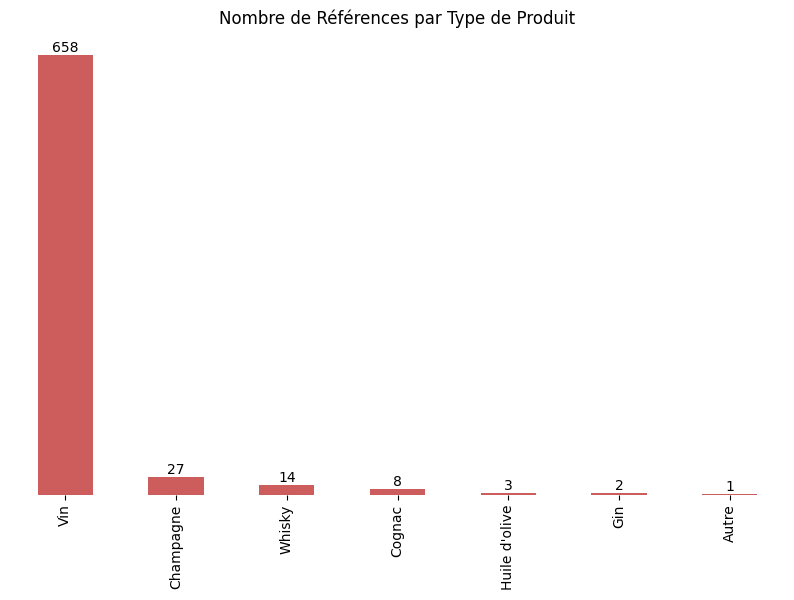

In [ ]:
# Création d'un graphique des occurrences par type de produit
plt.figure(figsize=(10, 6))
ax = df_final['product_type'].value_counts().plot(kind='bar', color='indianred')

# Ajout des valeurs au-dessus des barres
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, color='black')

# Retirer le cadre
ax.spines[:].set_visible(False)

# Supprimer l'axe Y et son label
ax.get_yaxis().set_visible(False)

# Garder l'axe X visible mais retirer le label
plt.xlabel("")

# Ajout d'un titre
plt.title("Nombre de Références par Type de Produit")

# Afficher le graphique
plt.show()


La représensation empirique des types de produits nous permet de constater que le vin est notre principal marché, notre gamme est ensuite diversifiée avec des spiritueux et de l'huile d'olive.

Il serait intéressant d'analyser la pertinence de cette diversité surtout après ce constat du nombre de références dans chacune des catégories.

##**Etape 5** - Analyse de la variable price

###**5.1** - Analyse par histogramme

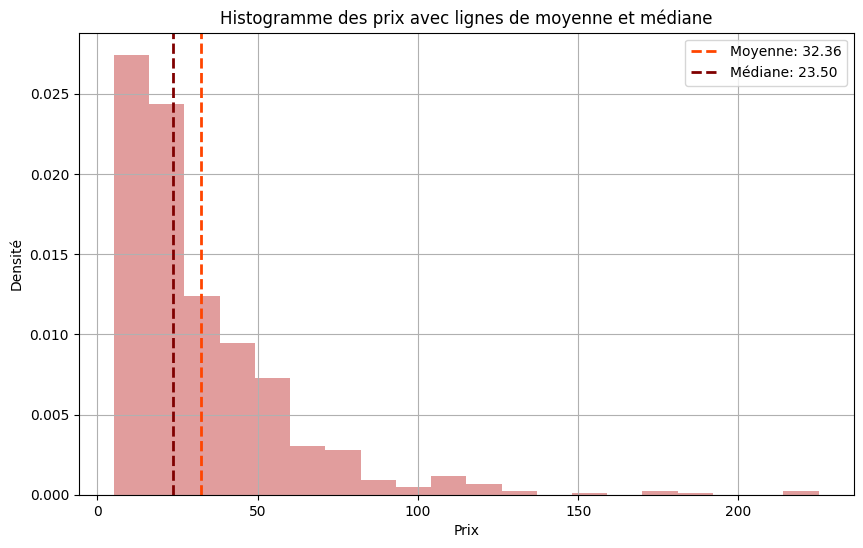

Mode = 0    19.0
Name: price, dtype: float64
Skewness = 2.601204527959599


In [ ]:
# Calcul des moyenne et médiane pour le graphique
moyenne = df_final['price'].mean()
mediane = df_final['price'].median()

# Création d'un 'histogramme
plt.figure(figsize=(10, 6))
df_final['price'].hist(density=True, bins=20, alpha=0.6, color='indianred')

# Ajout des lignes verticales pour la moyenne et la médiane
plt.axvline(moyenne, color='orangered', linestyle='dashed', linewidth=2, label=f'Moyenne: {moyenne:.2f}')
plt.axvline(mediane, color='maroon', linestyle='dashed', linewidth=2, label=f'Médiane: {mediane:.2f}')

# Ajout des labels et de la légende
plt.xlabel('Prix')
plt.ylabel('Densité')
plt.title('Histogramme des prix avec lignes de moyenne et médiane')
plt.legend()

# Affichage du graphique, du mode et du skewness
plt.show()
print(f"Mode = {df_final['price'].mode()}")
print(f"Skewness = {df_final['price'].skew()}")

La distribution est étalée à droite, confirmé par un skewness supérieur à 0 (***Mode < Med < x***)

Une population importante se situe en dessous de **50€** mais plusieurs outliers pouvant être supérieurs à **200€**. Le **mode** soit la valeur qui revient le plus souvent est à **19€**, nous pouvons aussi constater sur le graphique une **moyenne** à **32€** supérieure à la **médiane** à **23€**, un constat rapide pour nous indiquer des produits ayant un prix élevé qui tirent la **moyenne** vers le haut.

###**5.2** - Analyse par boxplot

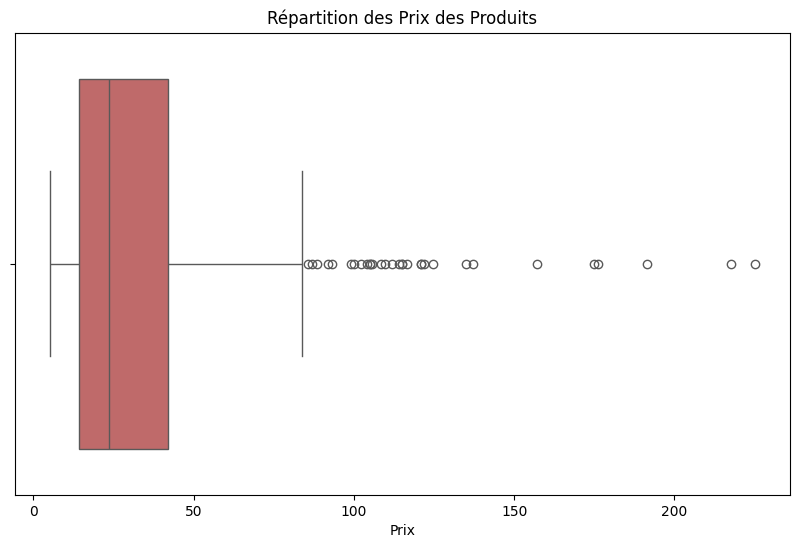

,price
count,713.000000
mean,32.361290
std,27.605837
min,5.200000
25%,14.100000
50%,23.500000
75%,42.100000
max,225.000000


In [ ]:
# Créer une figure et un axe
plt.figure(figsize=(10, 6))

# Création du boxplot
sns.boxplot(x=df_final['price'], color='indianred')

# Ajout du titre et des labels
plt.title('Répartition des Prix des Produits')
plt.xlabel('Prix')

# Afficher le graphique
plt.show()
df_final['price'].describe()

Ce graphique nous permet de mettre en évidence les **outliers** qui se trouvent au delà de **80€** (a confirmer par calcul) et s'étendent aux maximum à **225€**.

La **médiane** n'est pas **centrée** donc **inférieure** à la **moyenne**, même constat que le graphique précédent les **outliers** tirent la **moyenne** vers le haut.

Nous allons maintenant calculer le seuil des articles outliers grâce à la formule suivante :

***outlier_sup = Q3 + 1,5 x EI***

avec

***EI = écart interquartile =  Q3 - Q1***

***Q1 = premier quartile***

***Q3 = troisième quartile***

In [ ]:
q1 = 14.100
q3 = 42.100
ei = (q3-q1)
outlier_sup = q3 + (ei * 1.5)
print(f'le seuil des outliers est égal à {outlier_sup}')

le seuil des outliers est égal à 84.1


###**5.3** - Analyse des outliers

Maintenant que nous connaissons la valeur du seuil (**84,1**) définissons le nombre d'articles et la proportion de l'ensemble du catalogue "outliers".

In [ ]:
# Création d'un dataframe pour les produits dont le prix est supérieur à 84€
df_outlier = df_final.query('price > @outlier_sup')

# Trouver le nombre de produits "outliers"
outlier_size = len(df_outlier)

# Calcul de la proportion par rapport au catalogue complet
propor = round((len(df_outlier) / len(df_final))*100, 0)

print(f"Il y a {outlier_size} articles considérés comme outliers, soit {propor}% de la totalité des articles.")

Il y a 31 articles considérés comme outliers, soit 4.0% de la totalité des articles.


In [ ]:
comparaison = df_outlier[['price', 'purchase_price', 'product_type', 'post_title']]
display(comparaison)

,price,purchase_price,product_type,post_title
53,105.0,56.42,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...
85,104.0,46.71,Cognac,Cognac Frapin Cigar Blend
124,105.0,55.88,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...
144,115.0,59.42,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...
153,124.8,66.41,Vin,Domaine Weinbach Gewurztraminer Grand Cru Furs...
163,105.6,57.29,Vin,David Duband Chambolle-Musigny 1er Cru Les Sen...
210,175.0,90.42,Vin,Camille Giroud Clos de Vougeot 2016
212,157.0,69.08,Cognac,Cognac Frapin Château de Fontpinot 1989 20 Ans...
217,85.6,51.93,Champagne,Champagne Larmandier-Bernier Grand Cru Les Che...
226,137.0,67.95,Vin,Domaine Des Croix Corton Charlemagne Grand Cru...


Le prix de vente est cohérent au prix d'achat, il s'agit de bouteilles de vins et champagnes haut de gammes (1er cru, grand cru, millésime ancien), on retrouve aussi du whisky et du cognac.

**Les prix sont logiques et ne constituent en rien des valeurs aberrantes.**

##**Etape 6** - Analyses du CA, des quantités vendues, des stocks et de la marge

###**6.1** - Analyse du chiffre d'affaires

####**6.1.1** - Calcul du Chiffre d'affaires

In [ ]:
# Création d'une colonne calculant le chiffre d'affaires par article
df_final['ca'] = df_final['price'] * df_final['total_sales']

# Calcul de la somme de la colonne "ca_par_article"
total_ca = df_final['ca'].sum()

print(f"Le total du Chiffre d'Affaires (CA) du site web est de {round(total_ca, 2)}€ pour le mois d'octobre.")

Le total du Chiffre d'Affaires (CA) du site web est de 148714.1€ pour le mois d'octobre.


####**6.1.2** - Calcul du Chiffre d'affaires par type de produit

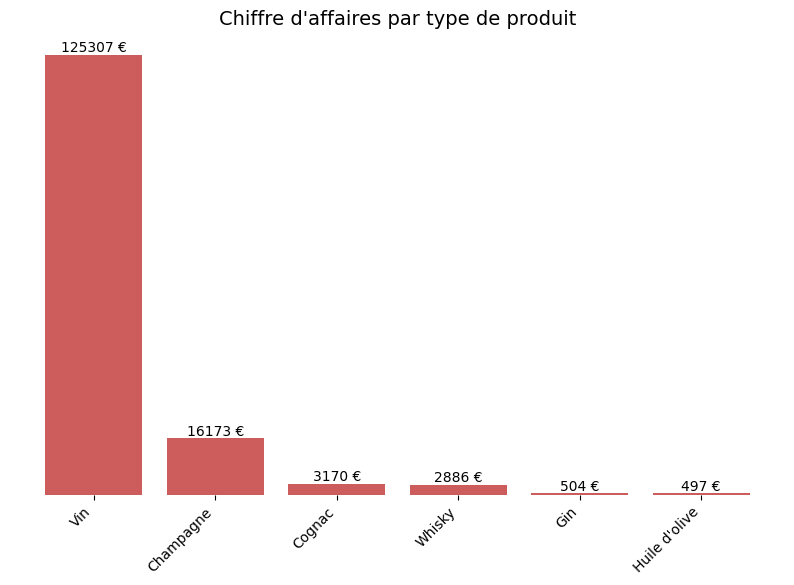

In [ ]:
# Calcul du chiffre d'affaires par type de produit
df_ca_par_type = df_final.groupby('product_type')['ca'].sum().reset_index()

# Exclusion des valeurs 'Autre'
df_ca_par_type = df_ca_par_type[df_ca_par_type['product_type'] != 'Autre']

# Tri du DataFrame par chiffre d'affaires en ordre décroissant
df_ca_par_type = df_ca_par_type.sort_values(by='ca', ascending=False)

# Affichage dans un graphique du chiffre d'affaires par type de produit
plt.figure(figsize=(10, 6))

# Création du graphique à barres
bars = plt.bar(df_ca_par_type['product_type'], df_ca_par_type['ca'], color='indianred')

# Ajout des valeurs avec € au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(yval)} €', ha='center', va='bottom', fontsize=10, color='black')

# Retirer le cadre
plt.gca().spines[:].set_visible(False)

# Retirer l'axe y et ses valeurs
plt.gca().yaxis.set_visible(False)

# Retirer les pointillés horizontaux
plt.grid(False)

# Enlever le titre de l'axe des x
plt.xlabel("")

# Titre du graphique
plt.title("Chiffre d'affaires par type de produit", fontsize=14)

# Rotation des étiquettes des x
plt.xticks(rotation=45, ha='right')

# Affichage du graphique
plt.show()

Le **vin** est dominant avec **125 307€** soit **84%** du chiffre d'affaires.

Un **champagne** timide avec **10%** de part du CA suivi par les **spiriteux** ne représentant que **4%** puis l'**huile d'olive** avec **0.3%**.

####**6.1.3** - Analyse du Top 20 par CA

Regardons de plus près le TOP 20 des articles avec le  plus grand CA.

<ipython-input-81-10b324d444b5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='post_title', x='ca', data=top_20_ca, palette=colors)


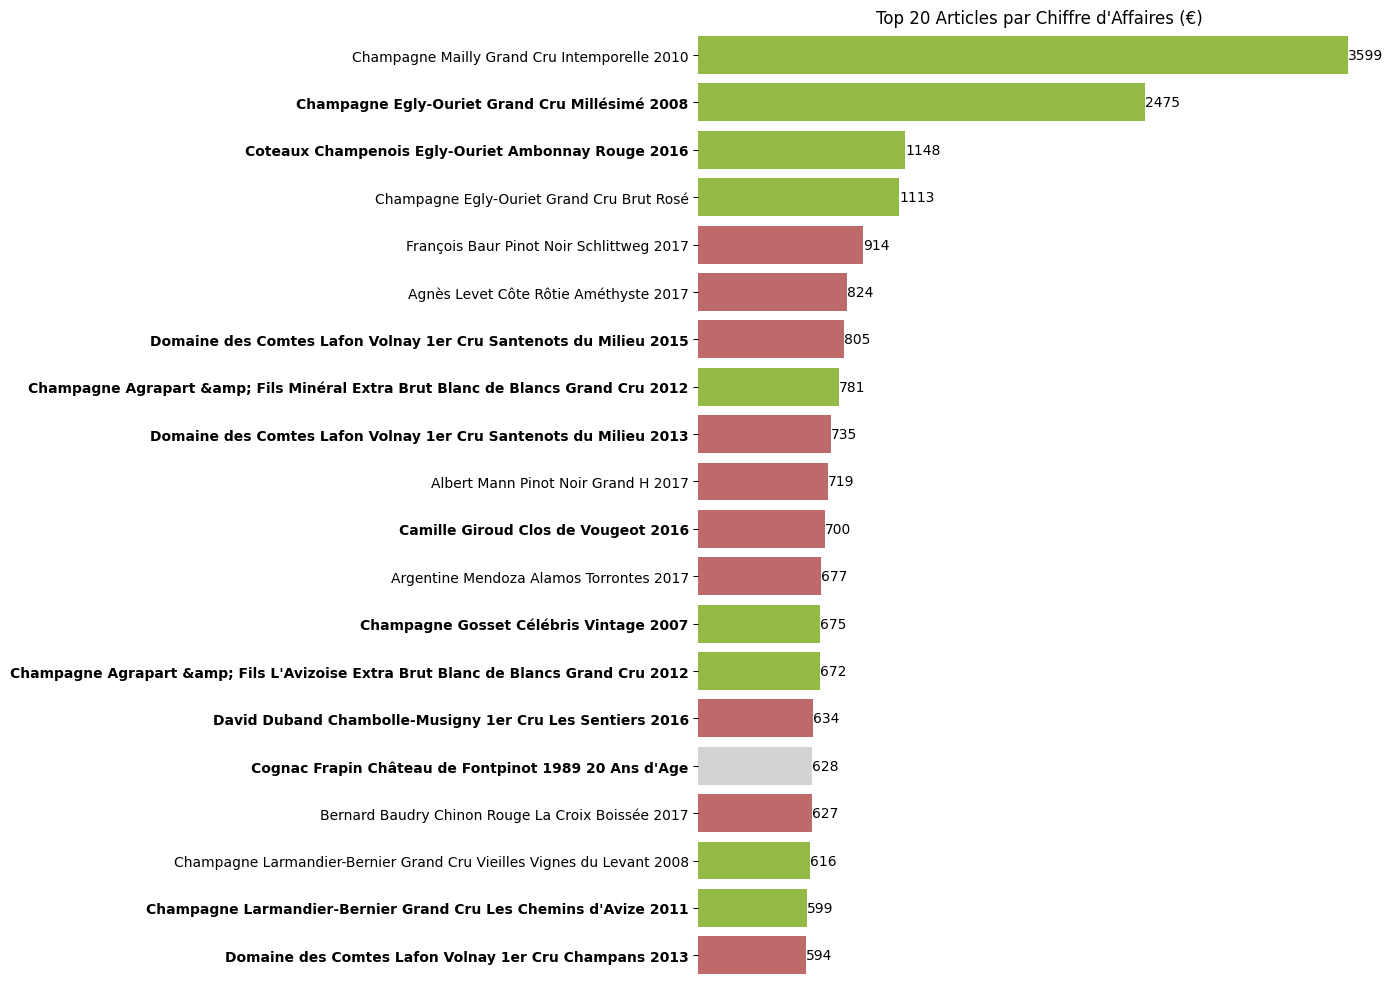

In [ ]:
# Tri dans l'ordre décroissant du Chiffre d'affaires
df_final = df_final.sort_values(by='ca', ascending=False).reset_index(drop=True)

# Affichage des 20 premiers articles en Chiffre d'affaires
top_20_ca = df_final.head(20)

# Création de la palette de couleurs en fonction du type de produit
colors = ['indianred' if product_type == 'Vin' else 'yellowgreen' if product_type == 'Champagne' else 'lightgray' for product_type in top_20_ca['product_type']]

# Création du graphique avec Seaborn
plt.figure(figsize=(14, 10))
ax = sns.barplot(y='post_title', x='ca', data=top_20_ca, palette=colors)

# Ajout des étiquettes au bout de chaque barre
for index, value in enumerate(top_20_ca['ca']):
    ax.text(value, index, f'{round(value)}', va='center', ha='left', fontsize=10, color='black')

# Rendre les titres en gras pour les produits dont le prix > 83.75 (outliers)
for index, post_title in enumerate(top_20_ca['post_title']):
    if top_20_ca['price'].iloc[index] > 83.75:
        ax.get_yticklabels()[index].set_fontweight('bold')

# Personnalisation des étiquettes et du titre
plt.ylabel('')
plt.title("Top 20 Articles par Chiffre d'Affaires (€)")

# Suppression de l'axe des x et sa ligne
plt.gca().axes.get_xaxis().set_visible(False)
sns.despine(left=True, bottom=True)

# Ajustement des marges
plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)

# Affichage du graphique
plt.tight_layout()
plt.show()

In [ ]:
df_final.head(20)

,product_id,sku,post_title,product_type,price,purchase_price,stock_quantity,total_sales,ca
0,4150,1366,Champagne Mailly Grand Cru Intemporelle 2010,Champagne,59.0,35.45,123,61,3599.0
1,4352,15940,Champagne Egly-Ouriet Grand Cru Millésimé 2008,Champagne,225.0,137.81,0,11,2475.0
2,5892,14983,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,Champagne,191.3,116.06,98,6,1147.8
3,4353,12587,Champagne Egly-Ouriet Grand Cru Brut Rosé,Champagne,79.5,45.91,127,14,1113.0
4,4726,14950,François Baur Pinot Noir Schlittweg 2017,Vin,12.7,6.82,0,72,914.4
5,5826,15325,Agnès Levet Côte Rôtie Améthyste 2017,Vin,41.2,21.71,34,20,824.0
6,6212,13996,Domaine des Comtes Lafon Volnay 1er Cru Santen...,Vin,115.0,59.42,16,7,805.0
7,5026,13913,Champagne Agrapart &amp; Fils Minéral Extra Br...,Champagne,86.8,50.13,101,9,781.2
8,5008,11602,Domaine des Comtes Lafon Volnay 1er Cru Santen...,Vin,105.0,56.42,12,7,735.0
9,5067,15346,Albert Mann Pinot Noir Grand H 2017,Vin,59.9,30.95,3,12,718.8


12 des 20 articles se trouvent être des bouteilles haut de gamme (outliers) et une répartition quasi égalitaire entre le vin et le champagne.

Les champagnes ont un stock élevés comparés aux autres produits, une prise d'avance pour préparer les ventes pour les fêtes de fin d'année ?

2 références sont à stock 0, il serait judicieux de comparer avec les ventes des mois précédents afin de voir s'il est intérressant d'en commander plus pour garantir plus de ventes.

####**6.1.4** - Analyse du flop en CA

In [ ]:
# Tri dans l'ordre croissant du Chiffre d'affaires
df_final = df_final.sort_values(by='ca', ascending=True).reset_index(drop=True)
df_final.head(25)

,product_id,sku,post_title,product_type,price,purchase_price,stock_quantity,total_sales,ca
0,5707,13557,Domaine des Terres d'Ocre Saint-Pourçain Rouge...,Vin,10.8,5.69,0,0,0.0
1,4337,4679,Champagne Mailly Grand Cru Les Echansons 2007,Champagne,83.0,48.90,145,0,0.0
2,3850,15300,Pierre Jean Villa Crozes-Hermitage Accroche Co...,Vin,20.8,10.64,0,0,0.0
3,4051,16045,Jeanne Gaillard IGP Collines Rhodaniennes Syra...,Vin,7.7,4.14,0,0,0.0
4,5932,523,Cognac Normandin Mercier VFC,Cognac,59.9,27.18,13,0,0.0
5,4198,16322,Moulin de Gassac IGP Pays d'Hérault Guilhem Ro...,Vin,5.8,2.97,0,0,0.0
6,4100,13416,Emile Boeckel Gewurztraminer Grand Cru Zotzenb...,Vin,15.8,8.57,0,0,0.0
7,5712,14241,Albert Mann Gewurztraminer Vendanges Tardives ...,Vin,57.6,30.36,0,0,0.0
8,4606,15149,Catherine et Claude Maréchal Volnay 2017,Vin,50.1,24.59,0,0,0.0
9,4047,14977,Pierre Gaillard Côtes-du-Rhône Blanc Les Gendr...,Vin,18.3,9.93,0,0,0.0


22 produits n'ont pas engendré de CA mais ces produits sont à stock 0.

Par contre 2 produits qui ont respectivement 13 bouteilles (cognac) et 145 bouteilles (champagne) en stock n'ont pas générer de CA.

Le champagne est un grand cru de 2007, c'est peut-être un produit qui trouvera preneur durant les fêtes cet hiver d'où sa grande quantité en stock.

Quant au cognac, c'est un produit qui ne trouve peut-être pas sa clientèle.

Les données provenant seulement du mois d'octobre je ne peux pas aller plus loin dans l'analyse.

####**6.1.5** - Calcul du 20/80 en CA

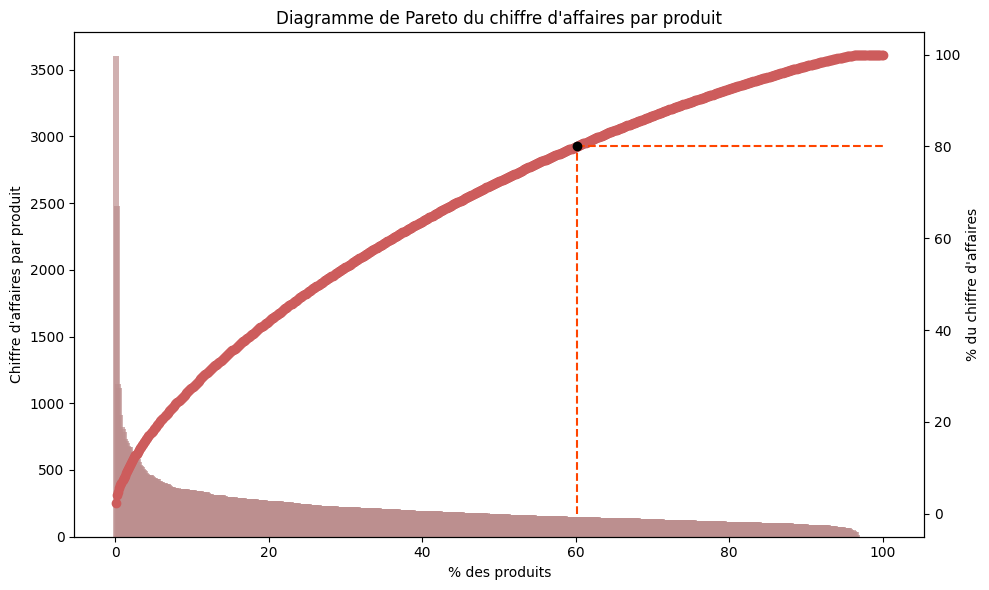

Nombre d'articles représentant 80% du CA : 428


In [ ]:
# Tri dans l'ordre décroissant du Chiffre d'affaires
df_final = df_final.sort_values(by='ca', ascending=False).reset_index(drop=True)

# Calculer la part du Chiffre d'affaires de chaque ligne dans le dataframe
df_final['%_ca'] = round((df_final['ca'] / df_final['ca'].sum()) * 100, 2)

# Créer une colonne réalisant la somme cumulative de la colonne précedemment créée
df_final['cumulative_%_ca'] = round(df_final['%_ca'].cumsum(), 2)

# Calculer le pourcentage des produits pour le graphique
df_final['product_percentage'] = (df_final.index + 1) / len(df_final) * 100

# Tracer le diagramme de Pareto
fig, ax1 = plt.subplots(figsize=(10, 6))

# Trouver le point où la courbe cumulative atteint 80% du CA
pareto_point_index = df_final[df_final['cumulative_%_ca'] >= 80].index[0]
pareto_x = df_final.loc[pareto_point_index, 'product_percentage']  # Pourcentage du produit correspondant à 80% du CA
pareto_y = df_final.loc[pareto_point_index, 'cumulative_%_ca']  # Cumulative % du CA (devrait être >= 80)

# Barres pour le chiffre d'affaires par article
ax1.bar(df_final['product_percentage'], df_final['ca'], color='rosybrown', alpha=0.7)
ax1.set_xlabel('% des produits')
ax1.set_ylabel('Chiffre d\'affaires par produit', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Courbe cumulative du CA
ax2 = ax1.twinx()  # créer un second axe partageant le même axe x
ax2.plot(df_final['product_percentage'], df_final['cumulative_%_ca'], color='indianred', marker='o', label='% du chiffre d\'affaires')
ax2.set_ylabel('% du chiffre d\'affaires', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Tracer la ligne horizontale jusqu'à la droite de la courbe cumulative
ax2.hlines(y=80, xmin=pareto_x, xmax=df_final['product_percentage'].max(), color='orangered', linestyle='--', label='80% CA')

# Tracer une ligne verticale depuis 80% du CA vers l'axe des x
ax2.vlines(x=pareto_x, ymin=0, ymax=pareto_y, color='orangered', linestyle='--')

# Ajouter un point d'intersection à 80% CA
ax2.scatter(pareto_x, pareto_y, color='black', zorder=5)

# Ajouter un titre
plt.title('Diagramme de Pareto du chiffre d\'affaires par produit')

fig.tight_layout()
plt.show()

# Calculer le nombre d'articles représentant 80% du CA
ca_80 = (df_final['cumulative_%_ca'] <= 80).sum()

print(f"Nombre d'articles représentant 80% du CA : {ca_80}")

60% de nos produits font 80% du chiffre d'affaires, autrement dit c'est la diversité de notre gamme qui nous permet d'atteindre nos chiffres.

###**6.2** - Analyse des ventes en Quantités

####**6.2.1** - Calcul des références vendues

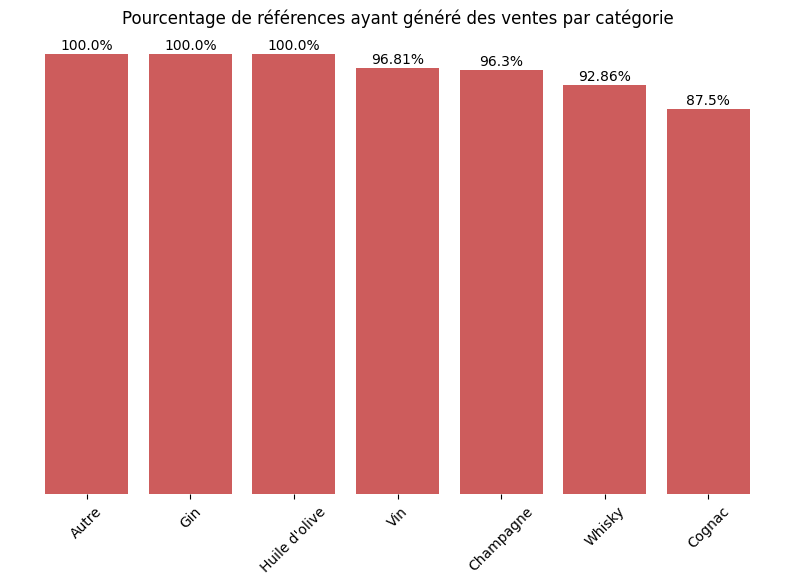

In [ ]:
# Filtrer les références qui ont engendré des ventes (total_sales > 0)
df_avec_ventes = df_final[df_final['total_sales'] > 0]

# Compter le nombre de références par catégorie ayant généré des ventes
ventes_par_categorie = df_avec_ventes.groupby('product_type')['product_id'].count()

# Compter le nombre total de références par catégorie
total_par_categorie = df_final.groupby('product_type')['product_id'].count()

# Calcul du pourcentage de références ayant généré des ventes par catégorie
pourcentage_ventes = (ventes_par_categorie / total_par_categorie) * 100

# Créer un DataFrame pour mieux visualiser le résultat
df_pourcentage_ventes = pd.DataFrame({
    'total_references': total_par_categorie,
    'references_avec_ventes': ventes_par_categorie,
    'pourcentage_ventes': pourcentage_ventes
}).reset_index()

# Remplacer les valeurs NaN par 0 pour les catégories sans ventes
df_pourcentage_ventes.fillna(0, inplace=True)

# Trier le DataFrame par le pourcentage de ventes en ordre décroissant
df_pourcentage = df_pourcentage_ventes[['product_type', 'pourcentage_ventes']].sort_values(by='pourcentage_ventes', ascending=False)

# Création du graphique
plt.figure(figsize=(10, 6))
plt.bar(df_pourcentage['product_type'], df_pourcentage['pourcentage_ventes'], color='indianred')

# Ajouter des étiquettes pour chaque barre
for i in range(len(df_pourcentage)):
    plt.text(i, df_pourcentage['pourcentage_ventes'].iloc[i] + 0.5,
             f"{round(df_pourcentage['pourcentage_ventes'].iloc[i], 2)}%",
             ha='center', va='bottom', fontsize=10, color='black')

# Retirer le cadre en haut et à droite
plt.gca().spines[:].set_visible(False)

# Supprimer l'axe Y et son titre
plt.gca().axes.get_yaxis().set_visible(False)

# Titres et labels
plt.xlabel("")
plt.title("Pourcentage de références ayant généré des ventes par catégorie")

# Rotation des labels de l'axe X pour éviter le chevauchement
plt.xticks(rotation=45)

# Affichage du graphique
plt.show()


Presque toutes les références du catalogue ont généré des ventes au mois d'octobre.

####**6.2.2** - Calcul des quantités vendues

In [ ]:
# Calcul de la somme de la colonne "total_sales"
total_sales = df_final['total_sales'].sum()

print(f"Le total des ventes du site web est de {round(total_sales, 2)} bouteilles pour le mois d'octobre.")

Le total des ventes du site web est de 5916 bouteilles pour le mois d'octobre.


####**6.2.3** - Calcul des quantités vendues par type de produit

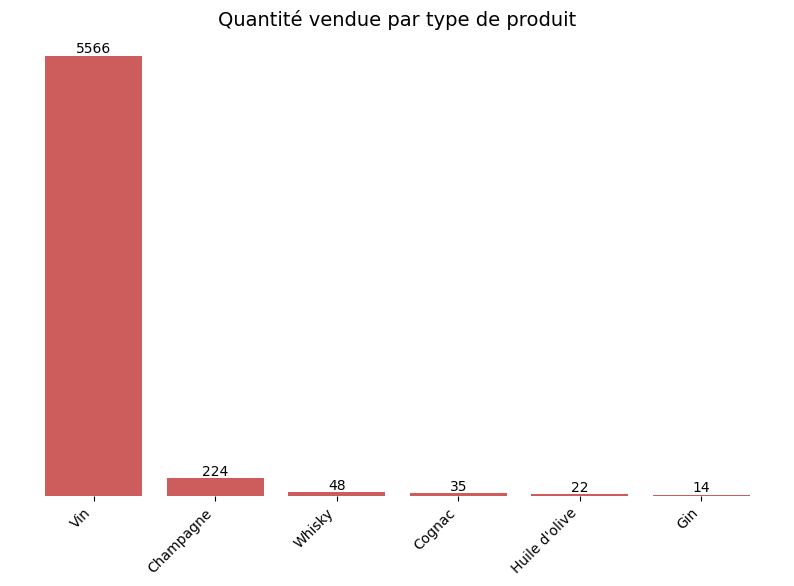

In [ ]:
# Calcul des ventes par type de produit
df_vente_par_type = df_final.groupby('product_type')['total_sales'].sum().reset_index()

# Exclusion des valeurs 'Autre'
df_vente_par_type = df_vente_par_type[df_vente_par_type['product_type'] != 'Autre']

# Tri du DataFrame par ventes en ordre décroissant
df_vente_par_type = df_vente_par_type.sort_values(by='total_sales', ascending=False)

# Affichage dans un graphique des ventes par type de produit
plt.figure(figsize=(10, 6))

# Création du graphique à barres
bars = plt.bar(df_vente_par_type['product_type'], df_vente_par_type['total_sales'], color='indianred')

# Ajout des valeurs au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(yval)}', ha='center', va='bottom', fontsize=10, color='black')

# Retirer le cadre
plt.gca().spines[:].set_visible(False)

# Retirer l'axe y et ses valeurs
plt.gca().yaxis.set_visible(False)

# Retirer les pointillés horizontaux
plt.grid(False)

# Enlever le titre de l'axe des x
plt.xlabel("")

# Titre du graphique
plt.title("Quantité vendue par type de produit", fontsize=14)

# Rotation des étiquettes des x
plt.xticks(rotation=45, ha='right')

# Affichage du graphique
plt.show()

Le **vin** représente **94%** des ventes avec **5566** bouteilles, le **champagne** **4%**, les **spiritueux** **2%** et enfin **les huiles d'olives 0.3%**.

####**6.2.4** - Analyse du Top 20 par quantité

<ipython-input-88-464be1ca01ce>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='post_title', x='total_sales', data=top_20_sales, palette=colors)


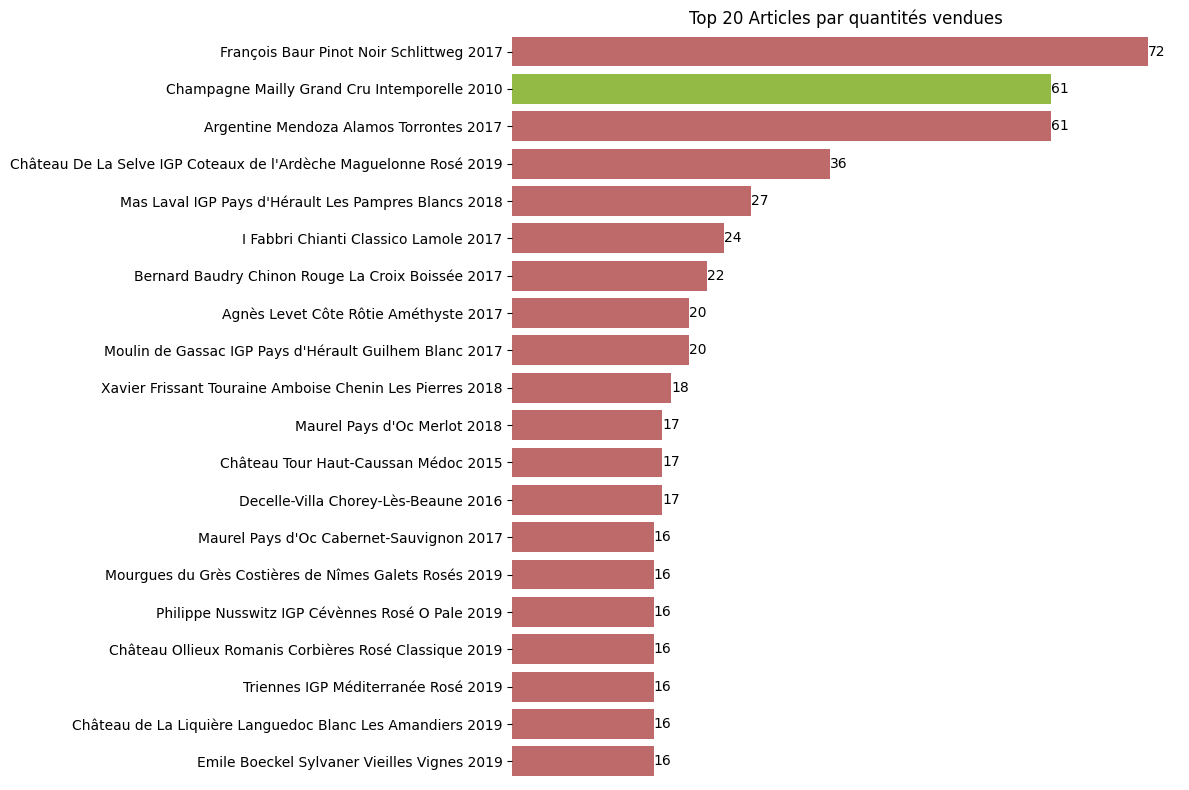

In [ ]:
# Tri dans l'ordre décroissant de quantités vendues
df_final = df_final.sort_values(by='total_sales', ascending=False).reset_index(drop=True)

# Affichage des 20 premiers articles en quantité
top_20_sales = df_final.head(20)

# Création de la palette de couleurs en fonction du type de produits
colors = ['indianred' if product_type == 'Vin' else 'yellowgreen' if product_type == 'Champagne' else 'lightgray' for product_type in top_20_sales['product_type']]

# Création du graphique avec Seaborn
plt.figure(figsize=(12, 8))
ax = sns.barplot(y='post_title', x='total_sales', data=top_20_sales, palette=colors)

# Ajout des étiquettes au bout de chaque barre
for index, value in enumerate(top_20_sales['total_sales']):
    ax.text(value, index, f'{round(value)}', va='center', ha='left', fontsize=10, color='black')

# Rendre les titres en gras pour les produits dont le prix > 83.75 (outliers)
for index, post_title in enumerate(top_20_sales['post_title']):
    if top_20_sales['price'].iloc[index] > 83.75:
        ax.get_yticklabels()[index].set_fontweight('bold')

# Personnalisation des étiquettes et du titre
plt.ylabel('')
plt.title('Top 20 Articles par quantités vendues')

# Suppression de l'axe des x et sa ligne
plt.gca().axes.get_xaxis().set_visible(False)
sns.despine(left=True, bottom=True)

# Affichage du graphique
plt.tight_layout()
plt.show()

In [ ]:
display(top_20_sales)

,product_id,sku,post_title,product_type,price,purchase_price,stock_quantity,total_sales,ca,%_ca,cumulative_%_ca,product_percentage
0,4726,14950,François Baur Pinot Noir Schlittweg 2017,Vin,12.7,6.82,0,72,914.4,0.61,6.21,0.701262
1,4150,1366,Champagne Mailly Grand Cru Intemporelle 2010,Champagne,59.0,35.45,123,61,3599.0,2.42,2.42,0.140252
2,5379,14561,Argentine Mendoza Alamos Torrontes 2017,Vin,11.1,5.68,33,61,677.1,0.46,9.73,1.683029
3,4867,16148,Château De La Selve IGP Coteaux de l'Ardèche M...,Vin,9.9,4.86,121,36,356.4,0.24,25.97,9.116410
4,4203,15415,Mas Laval IGP Pays d'Hérault Les Pampres Blanc...,Vin,9.9,5.01,74,27,267.3,0.18,42.38,20.336606
5,4275,14864,I Fabbri Chianti Classico Lamole 2017,Vin,14.9,7.78,62,24,357.6,0.24,24.77,8.415147
6,4647,16525,Bernard Baudry Chinon Rouge La Croix Boissée 2017,Vin,28.5,14.14,45,22,627.0,0.42,11.90,2.384292
7,5826,15325,Agnès Levet Côte Rôtie Améthyste 2017,Vin,41.2,21.71,34,20,824.0,0.55,6.76,0.841515
8,6129,14570,Moulin de Gassac IGP Pays d'Hérault Guilhem Bl...,Vin,5.2,2.74,68,20,104.0,0.07,95.16,85.133240
9,4220,15758,Xavier Frissant Touraine Amboise Chenin Les Pi...,Vin,11.6,5.75,48,18,208.8,0.14,59.49,35.624123


In [ ]:
top_20_sales['price'].mean()

15.530000000000001

Contrairement au Top 20 par rapport au CA, nous remarquons ici une dominance du **vin**.

On constate ici des références dont le prix de vente n'est pas excessif (**15€** en moyenne), ce qui génère beaucoup de ventes. De plus aucune référence haut de gamme ne se trouve dans le top 20.

Enfin, nous avons  du stock sur quasi toutes les références hormis 2 vins dont une référence identique au Top20 CA, même analyse à faire sur les mois précédents.

####**6.2.5** - Calcul du 20/80 en quantité vendues

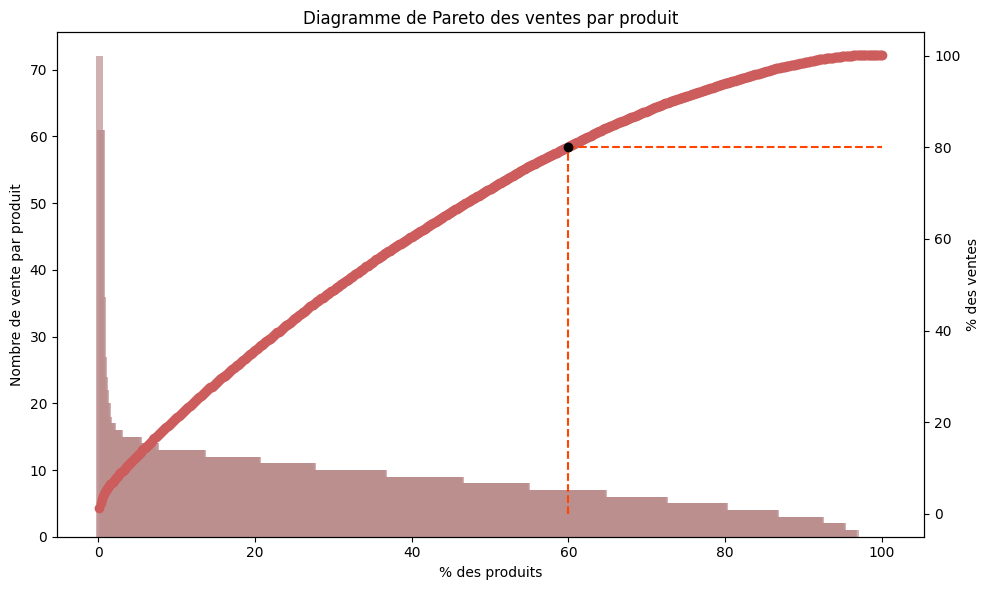

Nombre d'articles représentant 80% des quantités vendues : 426


In [ ]:
# Création d'une colonne calculant la part en quantité de la ligne dans le dataset
df_final['%_sales'] = round((df_final['total_sales'] / df_final['total_sales'].sum()) * 100, 2)

# Création d'une colonne réalisant la somme cumulative de la colonne précedemment créée
df_final['cumulative_%_sales'] = round(df_final['%_sales'].cumsum(), 2)

# Calculer le pourcentage des produits pour le graphique
df_final['product_percentage'] = (df_final.index + 1) / len(df_final) * 100

# Tracer le diagramme de Pareto
fig, ax1 = plt.subplots(figsize=(10, 6))

# Trouver le point où la courbe cumulative atteint 80% des quantités vendues
pareto_point_index = df_final[df_final['cumulative_%_sales'] >= 80].index[0]
pareto_x = df_final.loc[pareto_point_index, 'product_percentage']  # Pourcentage du produit correspondant à 80% des ventes
pareto_y = df_final.loc[pareto_point_index, 'cumulative_%_sales']  # Cumulative % des quantités vendues (devrait être >= 80)

# Barres pour les ventes par article
ax1.bar(df_final['product_percentage'], df_final['total_sales'], color='rosybrown', alpha=0.7)
ax1.set_xlabel('% des produits')
ax1.set_ylabel('Nombre de vente par produit', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Courbe cumulative des ventes
ax2 = ax1.twinx()  # créer un second axe partageant le même axe x
ax2.plot(df_final['product_percentage'], df_final['cumulative_%_sales'], color='indianred', marker='o', label='% des ventes')
ax2.set_ylabel('% des ventes', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Tracer la ligne horizontale jusqu'à la droite de la courbe cumulative
ax2.hlines(y=80, xmin=pareto_x, xmax=df_final['product_percentage'].max(), color='orangered', linestyle='--', label='80% Ventes')

# Tracer une ligne verticale depuis 80% des ventes vers l'axe des x
ax2.vlines(x=pareto_x, ymin=0, ymax=pareto_y, color='orangered', linestyle='--')

# Ajouter un point d'intersection à 80%
ax2.scatter(pareto_x, pareto_y, color='black', zorder=5)

# Ajouter un titre
plt.title('Diagramme de Pareto des ventes par produit')

fig.tight_layout()
plt.show()

# Calculer le nombre d'articles représentant 80% des quantités vendues
sales_80 = (df_final['cumulative_%_sales'] <= 80).sum()

print(f"Nombre d'articles représentant 80% des quantités vendues : {sales_80}")

On retrouve ici une répartition plus ou moins équitable par palier, la courbe est similaire a celle du CA.

###**6.3** - Analyse des stocks

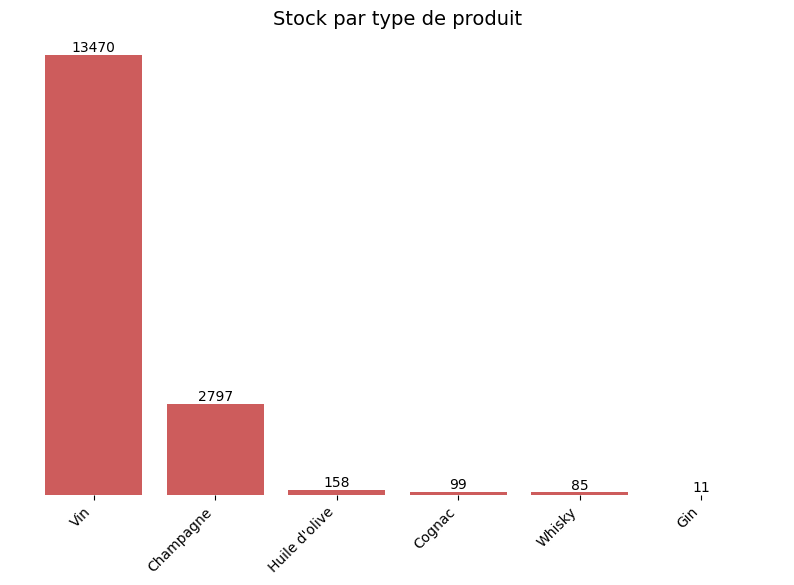

In [ ]:
# Calcul du stock par type de produit
df_stock_par_type = df_final.groupby('product_type')['stock_quantity'].sum().reset_index()

# Exclusion des valeurs 'Autre'
df_stock_par_type = df_stock_par_type[df_stock_par_type['product_type'] != 'Autre']

# Tri du DataFrame par taux de marge moyen en ordre décroissant
df_stock_par_type = df_stock_par_type.sort_values(by='stock_quantity', ascending=False)

# Affichage dans un graphique du stock par type de produit
plt.figure(figsize=(10, 6))

# Création du graphique à barres
bars = plt.bar(df_stock_par_type['product_type'], df_stock_par_type['stock_quantity'], color='indianred')

# Ajout des valeurs au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(yval)}', ha='center', va='bottom', fontsize=10, color='black')

# Retirer le cadre
plt.gca().spines[:].set_visible(False)

# Retirer l'axe y et ses valeurs
plt.gca().yaxis.set_visible(False)

# Retirer les pointillés horizontaux
plt.grid(False)

# Enlever le titre de l'axe des x
plt.xlabel("")

# Titre du graphique
plt.title("Stock par type de produit", fontsize=14)

# Rotation des étiquettes des x
plt.xticks(rotation=45, ha='right')

# Affichage du graphique
plt.show()

####**6.3.1** - Calcul du nombre de mois de stock

In [ ]:
# Calcul de la rotation de stock
df_final['rotation_stock'] = (df_final['total_sales'] / df_final['stock_quantity']).round(2).where(df_final['stock_quantity'] > 0, 0)

# Calcul du nombre de mois de stock
df_final['mois_de_stock'] = (df_final['stock_quantity'] / df_final['total_sales']).round(2).where(df_final['total_sales'] > 0, 0)

# Calcul du taux de rotation en pourcentage
df_final['taux_de_rotation'] = ((df_final['total_sales'] / df_final['stock_quantity']) * 100).round(2).where(df_final['stock_quantity'] > 0, 0)

# Affichage du DataFrame avec les nouvelles colonnes
df_final.head(5)

,product_id,sku,post_title,product_type,price,purchase_price,stock_quantity,total_sales,ca,%_ca,cumulative_%_ca,product_percentage,%_sales,cumulative_%_sales,rotation_stock,mois_de_stock,taux_de_rotation
0,4726,14950,François Baur Pinot Noir Schlittweg 2017,Vin,12.7,6.82,0,72,914.4,0.61,6.21,0.140252,1.22,1.22,0.00,0.00,0.00
1,4150,1366,Champagne Mailly Grand Cru Intemporelle 2010,Champagne,59.0,35.45,123,61,3599.0,2.42,2.42,0.280505,1.03,2.25,0.50,2.02,49.59
2,5379,14561,Argentine Mendoza Alamos Torrontes 2017,Vin,11.1,5.68,33,61,677.1,0.46,9.73,0.420757,1.03,3.28,1.85,0.54,184.85
3,4867,16148,Château De La Selve IGP Coteaux de l'Ardèche M...,Vin,9.9,4.86,121,36,356.4,0.24,25.97,0.561010,0.61,3.89,0.30,3.36,29.75
4,4203,15415,Mas Laval IGP Pays d'Hérault Les Pampres Blanc...,Vin,9.9,5.01,74,27,267.3,0.18,42.38,0.701262,0.46,4.35,0.36,2.74,36.49


<ipython-input-94-2678d8f994b0>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='post_title', x='mois_de_stock', data=flop_20_stock, palette=colors)


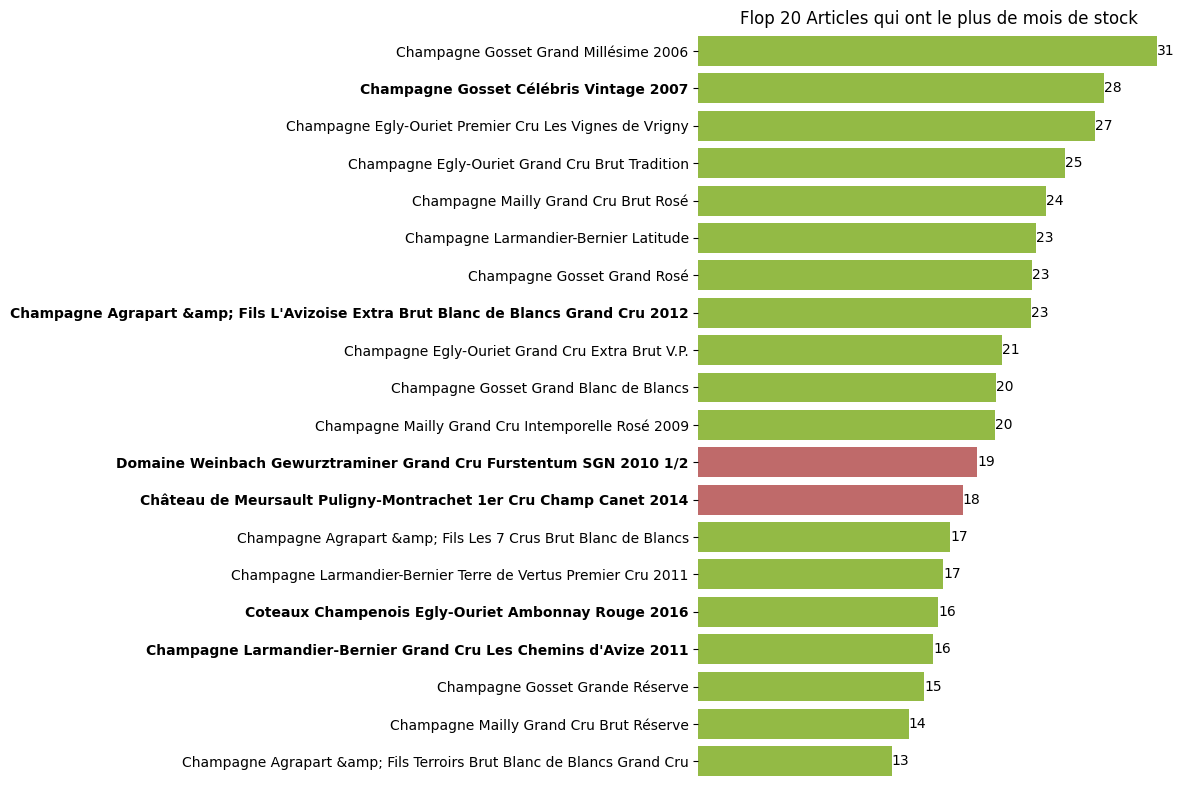

In [ ]:
# Tri dans l'ordre décroissant du nombre de mois de stock
df_final = df_final.sort_values(by='mois_de_stock', ascending=False).reset_index(drop=True)

# Affichage des 20 premiers articles en quantité stockée
flop_20_stock = df_final.head(20)

# Création de la palette de couleurs en fonction du product_type
colors = ['indianred' if product_type == 'Vin' else 'yellowgreen' if product_type == 'Champagne' else 'lightgray' for product_type in flop_20_stock['product_type']]

# Création du graphique avec Seaborn
plt.figure(figsize=(12, 8))
ax = sns.barplot(y='post_title', x='mois_de_stock', data=flop_20_stock, palette=colors)

# Ajout des étiquettes au bout de chaque barre
for index, value in enumerate(flop_20_stock['mois_de_stock']):
    ax.text(value, index, f'{round(value)}', va='center', ha='left', fontsize=10, color='black')

# Rendre les titres en gras pour les produits dont le prix > 83.75 (outliers)
for index, post_title in enumerate(flop_20_stock['post_title']):
    if flop_20_stock['price'].iloc[index] > 83.75:
        ax.get_yticklabels()[index].set_fontweight('bold')

# Personnalisation des étiquettes et du titre
plt.ylabel('')
plt.title('Flop 20 Articles qui ont le plus de mois de stock')

# Suppression de l'axe des x et sa ligne
plt.gca().axes.get_xaxis().set_visible(False)
sns.despine(left=True, bottom=True)

# Affichage du graphique
plt.tight_layout()
plt.show()

On ne retrouve presque que du champagne, ce qui semble logique pour plusieurs raisons :


*   Données issues du mois d'octobre, le gros des ventes de champagne est prévu pour les fêtes de fin d'année
*   Produit essentiellement acheté en grande quantité (caisse ou carton)

Pour les deux vins, il s'agit de bouteilles premium au delà de 100€, un produit exclusif.



####**6.3.2** - Valorisation des stocks en euros

In [ ]:
# Création de la colonne Valorisation des stocks en euros
df_final['valorisation_stock_euros'] = df_final['stock_quantity'] * df_final['price']

# Calcul de la somme de la colonne "Valorisation_stock_euros"
valo_sum = df_final['valorisation_stock_euros'].sum()

print(f"La totalité des produits en stock représente {round(valo_sum, 2)}€")

La totalité des produits en stock représente 493410.85€


####**6.3.3** - Valorisation du nombre de produit en stock

In [ ]:
# Calcul de la somme de la colonne stock quantity
stock_sum = df_final['stock_quantity'].sum()

print(f"Nous avons {stock_sum} produits en stock sur le mois d'octobre.")

Nous avons 16643 produits en stock sur le mois d'octobre.


####**6.3.4** - Taux de rotation global du site

In [ ]:
# Calcul du taux de rotation
tx_rotation = valo_sum / total_ca

print(f"Taux de rotation global de l'entreprise : {tx_rotation:.2f}")

Taux de rotation global de l'entreprise : 3.32


Un taux de rotation à 3.32 nous indique que certains produits se vendent mal ou pas et donc que l'on stocke beaucoup, le capital du site est figé dans ce stock accumulé.

###**6.4** - Analyse du taux de marge

In [ ]:
# Création de la colonne prix HT
df_final['price_ht'] = round(df_final['price'] / 1.20, 2)

# Création de la colonne Taux de marge
df_final['taux_marge'] = round(((df_final['price_ht'] - df_final['purchase_price']) / df_final['price_ht']) * 100, 2)

# Affichage du minimum de la colonne "taux_marge"
idx_min = df_final['taux_marge'].idxmin()
display(df_final.iloc[[idx_min]])
print(f"taux mini :{df_final['taux_marge'].min()}")

# Affichage du maximum de la colonne "taux_marge"
idx_max = df_final['taux_marge'].idxmax()
display(df_final.iloc[[idx_max]])
print(f"taux maxi :{df_final['taux_marge'].max()}")

,product_id,sku,post_title,product_type,price,purchase_price,stock_quantity,total_sales,ca,%_ca,cumulative_%_ca,product_percentage,%_sales,cumulative_%_sales,rotation_stock,mois_de_stock,taux_de_rotation,valorisation_stock_euros,price_ht,taux_marge
59,5760,11258,Huile d'Olive Extra Vierge Planeta 50cl,Huile d'olive,13.1,8.43,24,7,91.7,0.06,97.52,56.802244,0.12,77.43,0.29,3.43,29.17,314.4,10.92,22.8


taux mini :22.8


,product_id,sku,post_title,product_type,price,purchase_price,stock_quantity,total_sales,ca,%_ca,cumulative_%_ca,product_percentage,%_sales,cumulative_%_sales,rotation_stock,mois_de_stock,taux_de_rotation,valorisation_stock_euros,price_ht,taux_marge
539,4401,3506,Cognac Frapin VSOP,Cognac,62.5,27.21,5,3,187.5,0.13,66.11,92.00561,0.05,99.19,0.6,1.67,60.0,312.5,52.08,47.75


taux maxi :47.75


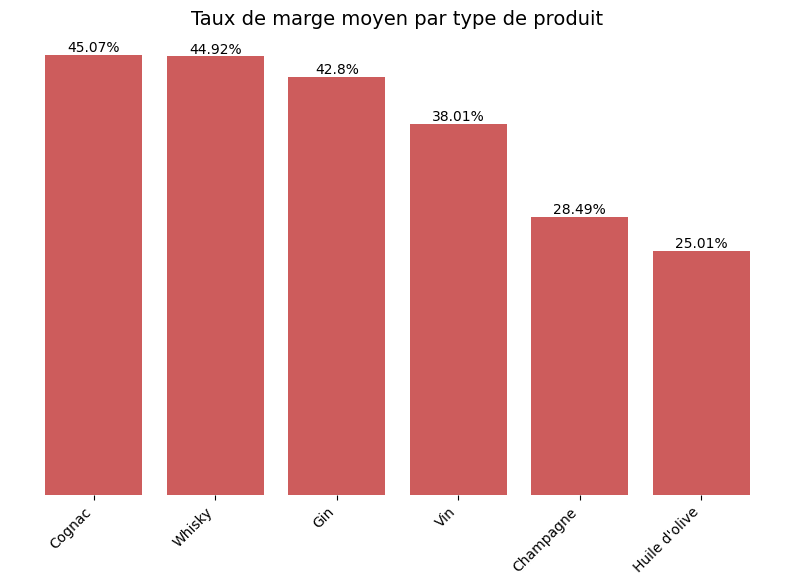

In [ ]:
# Création du DataFrame avec le taux de marge moyen par type de produit
df_marge_moyenne_par_type = df_final.groupby('product_type')['taux_marge'].mean().reset_index()

# Renommage des colonnes pour plus de clarté
df_marge_moyenne_par_type.columns = ['product_type', 'taux_marge_moyen']

# Exclusion des valeurs 'Autre'
df_marge_moyenne_par_type = df_marge_moyenne_par_type[df_marge_moyenne_par_type['product_type'] != 'Autre']

# Tri du DataFrame par taux de marge moyen en ordre décroissant
df_marge_moyenne_par_type = df_marge_moyenne_par_type.sort_values(by='taux_marge_moyen', ascending=False)

# Affichage dans un graphique du taux de marge par type de produit
plt.figure(figsize=(10, 6))

# Création du graphique à barres
bars = plt.bar(df_marge_moyenne_par_type['product_type'], df_marge_moyenne_par_type['taux_marge_moyen'], color='indianred')

# Ajout des valeurs avec % au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{round(yval, 2)}%', ha='center', va='bottom', fontsize=10, color='black')

# Retirer le cadre
plt.gca().spines[:].set_visible(False)

# Retirer l'axe y et ses valeurs
plt.gca().yaxis.set_visible(False)

# Retirer les pointillés horizontaux
plt.grid(False)

# Enlever le titre de l'axe des x
plt.xlabel('')

# Titre du graphique
plt.title('Taux de marge moyen par type de produit', fontsize=14)

# Rotation des étiquettes des x
plt.xticks(rotation=45, ha='right')

# Affichage du graphique
plt.show()

Les spiritueux (Cognac, Wisky, Gin) arrive en tête du classement avec un taux supérieur à 40%. Viens ensuite le vin, le champagne et l'huile d'olive.

J'ai volontairement masqué la catégorie 'Autre' puisqu'il s'agit de bons d'achats.

##**Etape 7** - Analyse des correlations

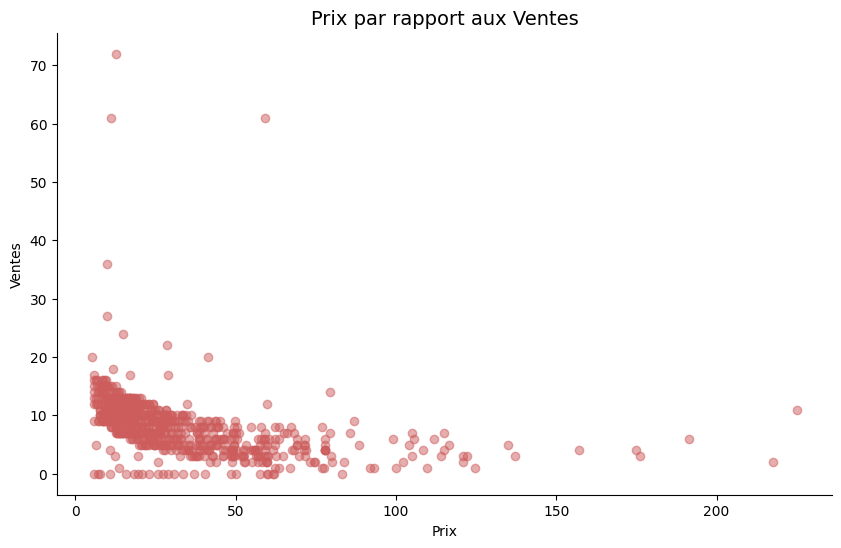

In [ ]:
# Création du scatter plot avec les ajustements requis
plt.figure(figsize=(10, 6))

# Création du scatter plot
plt.scatter(df_final['price'], df_final['total_sales'], color='indianred', alpha=0.5)

# Retirer le cadre en haut et à droite mais garder les axes X et Y
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Garder les axes X et Y visibles
plt.xlabel('Prix')
plt.ylabel('Ventes')

# Titre
plt.title('Prix par rapport aux Ventes', fontsize=14)

# Retirer le quadrillage
plt.grid(False)

# Affichage du graphique
plt.show()

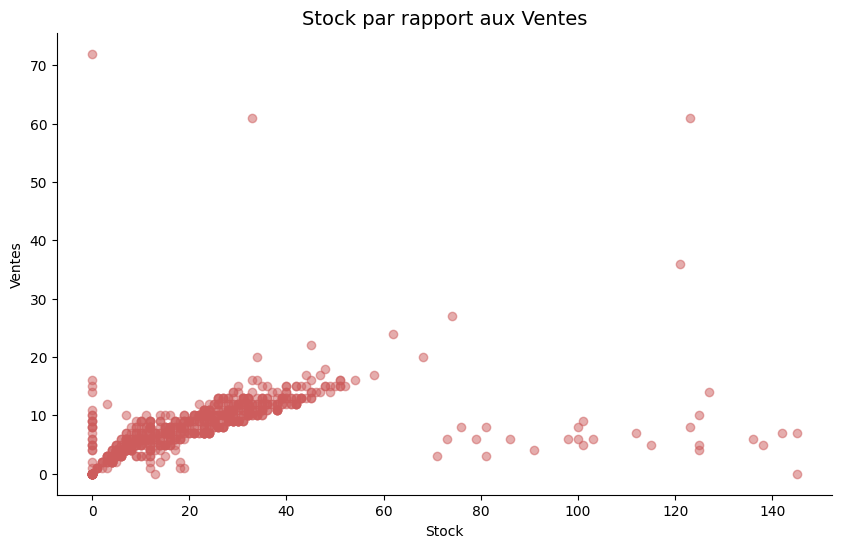

In [ ]:
# Création du scatter plot avec les ajustements requis
plt.figure(figsize=(10, 6))

# Création du scatter plot
plt.scatter(df_final['stock_quantity'], df_final['total_sales'], color='indianred', alpha=0.5)

# Retirer le cadre en haut et à droite mais garder les axes X et Y
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Garder les axes X et Y visibles
plt.xlabel('Stock')
plt.ylabel('Ventes')

# Titre
plt.title('Stock par rapport aux Ventes', fontsize=14)

# Retirer le quadrillage
plt.grid(False)

# Affichage du graphique
plt.show()

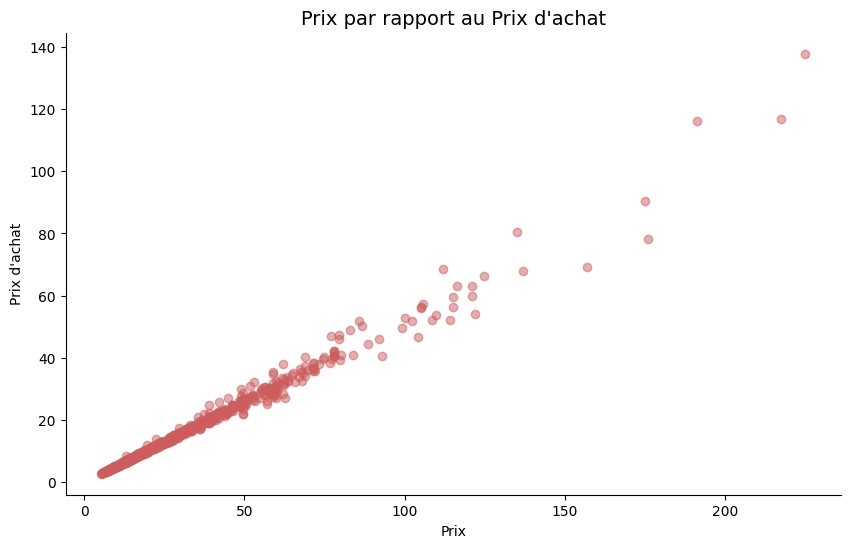

In [ ]:
# Création du scatter plot avec les ajustements requis
plt.figure(figsize=(10, 6))

# Création du scatter plot
plt.scatter(df_final['price'], df_final['purchase_price'], color='indianred', alpha=0.5)

# Retirer le cadre en haut et à droite mais garder les axes X et Y
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Garder les axes X et Y visibles
plt.xlabel('Prix')
plt.ylabel('Prix d\'achat')

# Titre
plt.title('Prix par rapport au Prix d\'achat', fontsize=14)

# Retirer le quadrillage
plt.grid(False)

# Affichage du graphique
plt.show()

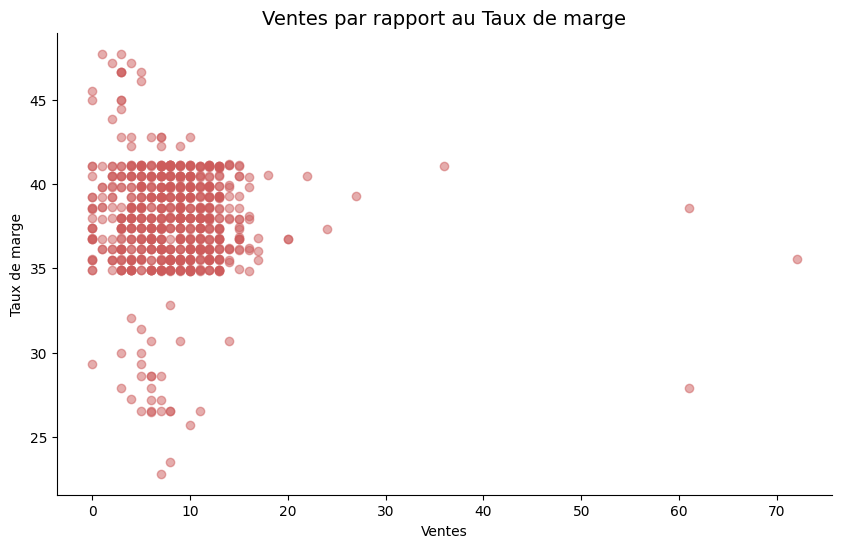

In [ ]:
# Création du scatter plot avec les ajustements requis
plt.figure(figsize=(10, 6))

# Création du scatter plot
plt.scatter(df_final['total_sales'], df_final['taux_marge'], color='indianred', alpha=0.5)

# Retirer le cadre en haut et à droite mais garder les axes X et Y
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Garder les axes X et Y visibles
plt.xlabel('Ventes')
plt.ylabel('Taux de marge')

# Titre
plt.title('Ventes par rapport au Taux de marge', fontsize=14)

# Retirer le quadrillage
plt.grid(False)

# Affichage du graphique
plt.show()

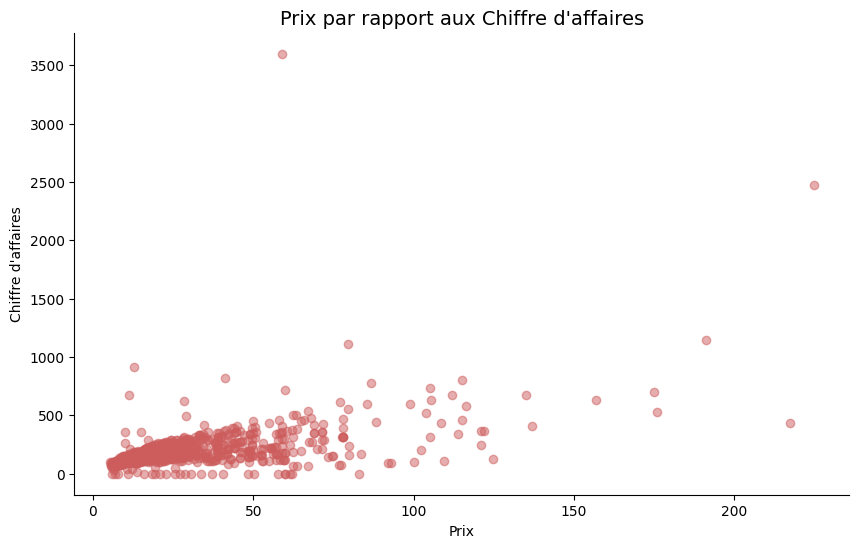

In [ ]:
# Création du scatter plot avec les ajustements requis
plt.figure(figsize=(10, 6))

# Création du scatter plot
plt.scatter(df_final['price'], df_final['ca'], color='indianred', alpha=0.5)

# Retirer le cadre en haut et à droite mais garder les axes X et Y
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Garder les axes X et Y visibles
plt.xlabel('Prix')
plt.ylabel('Chiffre d\'affaires')

# Titre
plt.title('Prix par rapport aux Chiffre d\'affaires', fontsize=14)

# Retirer le quadrillage
plt.grid(False)

# Affichage du graphique
plt.show()

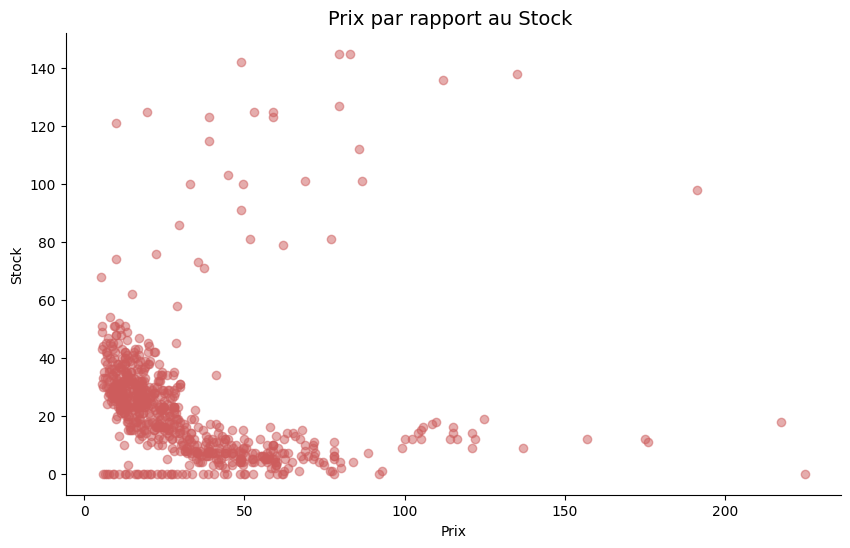

In [ ]:
# Création du scatter plot avec les ajustements requis
plt.figure(figsize=(10, 6))

# Création du scatter plot
plt.scatter(df_final['price'], df_final['stock_quantity'], color='indianred', alpha=0.5)

# Retirer le cadre en haut et à droite mais garder les axes X et Y
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Garder les axes X et Y visibles
plt.xlabel('Prix')
plt.ylabel('Stock')

# Titre
plt.title('Prix par rapport au Stock ', fontsize=14)

# Retirer le quadrillage
plt.grid(False)

# Affichage du graphique
plt.show()

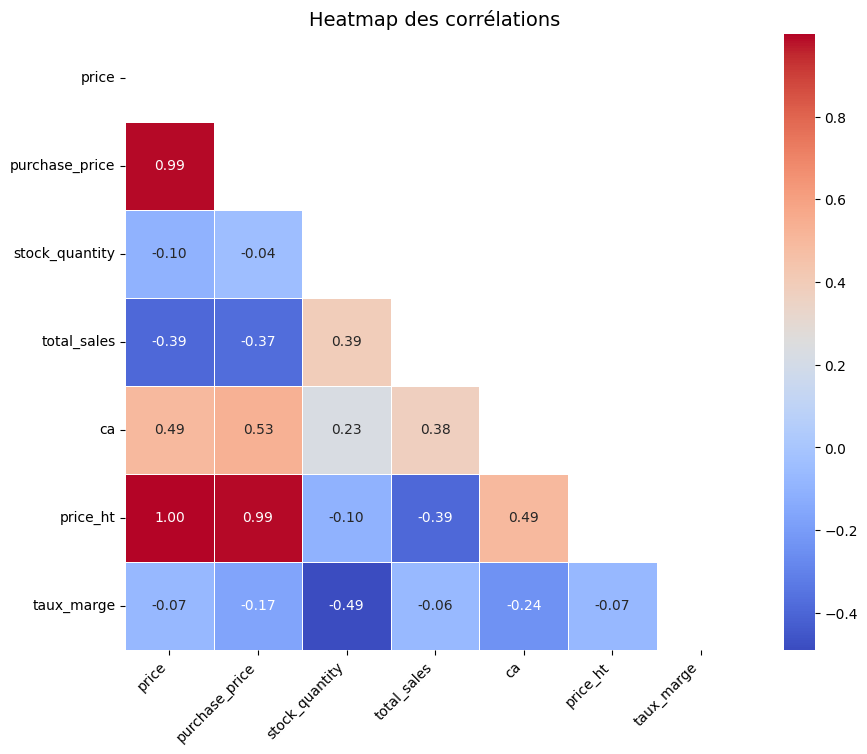

In [ ]:
# Calcul de la matrice de corrélation
corr_matrix = df_final[['price', 'purchase_price', 'stock_quantity', 'total_sales', 'ca', 'price_ht', 'taux_marge']].corr()

# Masque pour masquer la moitié supérieure de la matrice
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Création de la heatmap avec un plus grand graphique, rotation des étiquettes et ajustement de la taille de police
plt.figure(figsize=(10, 8))  # Agrandir la figure pour plus de lisibilité
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True, mask=mask, annot_kws={"size": 10})  # Taille de police ajustée

# Rotation des étiquettes pour éviter qu'elles se chevauchent
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Ajout d'un titre
plt.title("Heatmap des corrélations", fontsize=14)

# Affichage du graphique
plt.show()


On constate une corrélation forte entre les variables "**price**", "**price_ht**" et "**purchase_price**", on peut dire que ces variables sont **liés**.

Une corrélation à **-0,39** entre les variables "**price**" et "**total_sales**" ; c'est-à-dire que plus le prix de vente augmente moins il y a de vente.

Enfin il y a une corrélation à **0,39** entre "**total_sales**" et "**stock_quantity**" ; plus il y a de vente plus il y a de stock.

##**Etape 8** - Mise à disposition de la nouvelle table en Excel

In [ ]:
df_final.to_excel('data_final.xlsx', index=False)